## Preprocessing & EDA

This section will focus on the following aspects crucial to data analysis:
*  Conducting Exploratory Data Analysis (**EDA**)
*  Engineering **new features to mitigate normalization challenges** inherent in the original dataset.
*  Addressing **outliers** within the dataset
*  Investigating the new features
*  Performing **Statistical Data Analysis**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pickle

In [2]:
import sys
sys.path.append("..")

from src.data_transformers import outlim_to_tuple

### Dataset

The dataset consists of two types of samples: those **embedded in paraffin and those after deparaffinization**. To **mitigate data leakage, we'll strictly utilize the training data**, specifically from the patient-level split dataset.

In [3]:
# import the datasets
train_PAR_patient = pd.read_csv('../data/train_PAR_patient.csv')
train_DEP_patient = pd.read_csv('../data/train_DEP_patient.csv')

## 1. Data exploration

The dataset contains the following columns:

In [4]:
train_PAR_patient.columns

Index(['Patient', 'Sample', 'Category', 'Lipids', 'Unsaturated lipids',
       'CH3 groups', 'CH2 groups', 'Ester groups',
       'Unsaturated/saturated lipid ratio', 'Lipid saturation',
       'Carbonyl/lipid ratio', 'Amide I', 'Lipid/protein ratio', 'Alpha helix',
       'Beta sheets', 'Beta turns', 'Alpha helix/beta sheets',
       'Percentage of beta forms', 'Band 1450', 'Band 1390', 'Band 1240',
       'Band 1080', 'Band 1310', 'Band 2850', 'Band 3060', 'Biomass_I',
       'Biomass_II', 'Biomass_Total'],
      dtype='object')

Besides the columns representing the origin and category of the samples, there are additional columns containing information about the intensity of IR peaks. Furthermore, some columns already show ratios of intensities. Let's have a look at the values in those columns.

In [5]:
train_PAR_patient.describe()

,Lipids,Unsaturated lipids,CH3 groups,CH2 groups,Ester groups,Unsaturated/saturated lipid ratio,Lipid saturation,Carbonyl/lipid ratio,Amide I,Lipid/protein ratio,...,Band 1450,Band 1390,Band 1240,Band 1080,Band 1310,Band 2850,Band 3060,Biomass_I,Biomass_II,Biomass_Total
count,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,...,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000
mean,35.508742,-0.016852,3.158983,16.054825,-0.173601,-0.008055,5.052958,-0.005236,5.714498,8.512385,...,1.398406,0.476344,0.393570,0.725667,0.026784,5.814356,0.087951,45.257090,34.000116,79.257206
std,11.679008,0.005528,1.079200,5.686676,0.070753,0.171228,1.373080,0.171264,2.513006,80.110904,...,0.433627,0.146936,0.161557,0.577079,0.025731,1.943406,0.057000,15.225508,12.553795,26.091457
min,-0.017618,-0.079906,-0.022677,0.000723,-0.559956,-20.574695,-12.500501,-9.467781,-0.479894,-3182.502180,...,-0.011090,-0.132053,-0.086068,-0.138383,-0.202773,0.001898,-0.175046,-8.158055,-14.782044,-17.840006
25%,31.452936,-0.019842,2.670191,14.204567,-0.220255,-0.006095,4.373478,-0.006580,3.987826,4.702424,...,1.182823,0.386485,0.289773,0.464356,0.016903,5.236549,0.053403,37.014049,26.879172,64.203101
50%,37.792600,-0.016926,3.264438,17.601679,-0.177021,-0.005166,5.284103,-0.004674,6.002522,6.288154,...,1.412089,0.489412,0.407112,0.602629,0.029730,6.203258,0.089605,48.251413,34.388698,82.318400
75%,43.326807,-0.013915,3.855224,19.960230,-0.126875,-0.004580,5.814490,-0.003594,7.386763,8.575766,...,1.646005,0.554875,0.504551,0.774763,0.041119,7.076611,0.117680,54.826830,41.365669,94.939465
max,85.482173,0.000388,12.273891,29.254765,0.332083,1.315750,100.891181,17.282730,18.016197,4662.804150,...,4.365792,1.673367,1.327351,5.472854,0.215199,11.516098,0.738455,131.239033,114.385624,237.947558


We've noticed a **significant number of negative values in the data**. Typically, negative values hold no physical significance, as concentrations cannot be negative. However, in this context, negative values indicate that the baseline in the spectrum exceeds the peak, which can occur when very few or no counts are observed. Despite this, negative values still provide valuable information about the spectrum's shape. Therefore, I will retain these variables for the time being.

### 1.A. Data distribution

Let's examine the distribution of peak intensities between the paraffin-embedded and deparaffinized samples for Biomass_Total, which accurately reflects the sample's composition, as well as another column exhibiting high counts.

In [6]:
# Identify column with high counts (excluding Biomass and columns which are ratios of peak areas)
# Selecting numeric columns that do not contain specified substrings in their names
numeric_columns = train_PAR_patient.select_dtypes(include='number').filter(regex='^(?!.*(?:ercentage|ratio|iomass)).*$')

# Calculating median values for each column
median_values = numeric_columns.median()

# Selecting three column names with the highest median values
top_3_columns = median_values.nlargest(3).index.tolist()

print("Columns with the highest median values:")
print(top_3_columns)

Columns with the highest median values:
['Lipids', 'CH2 groups', 'Band 2850']


In [7]:
# Create colour palette
palette = ["#58508d","#ff6361"]

<Axes: xlabel='Biomass_Total', ylabel='Count'>

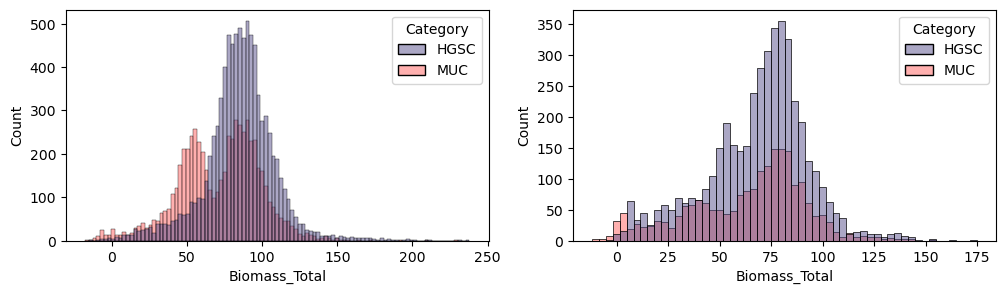

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,3))
sns.histplot(train_PAR_patient, x='Biomass_Total', hue='Category', ax=ax1, palette = palette)
sns.histplot(train_DEP_patient, x='Biomass_Total', hue='Category', ax=ax2, palette = palette)

<Axes: xlabel='Band 2850', ylabel='Count'>

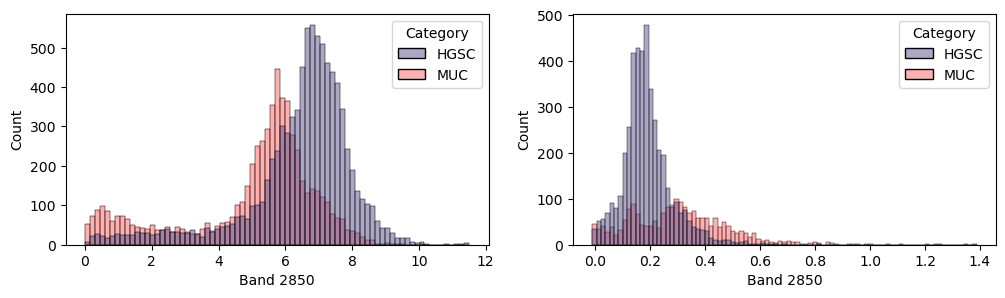

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,3))
sns.histplot(train_PAR_patient, x='Band 2850', hue='Category', ax=ax1, palette = palette)
sns.histplot(train_DEP_patient, x='Band 2850', hue='Category', ax=ax2, palette = palette)

We observe that both paraffin-embedded and deparaffinized samples of both HGSC and MUC exhibit **multimodal distributions**. This could be attributed to improper or absent normalization of spectra. Variations in specimen thickness or density may lead to differences in counts under peaks among specimens. 

**To tackle this issue, we will compute ratios of these counts instead of using the counts directly. This approach will mitigate normalization concerns.**

### 1.B. Differences between HGSC and MUC

Before proceeding further, let's **assess whether there are statistically significant differences between HGSC and MUC samples**.

Given that the samples do **not follow normal distributions, we will employ the Mann-Whitney U test**, a non-parametric test that does not assume normality. However, when conducting multiple hypothesis tests simultaneously (in this case, across multiple columns between two datasets), we must address the heightened risk of false positives. To mitigate this, we will apply the **Bonferroni correction**, adjusting the significance level (the p-value threshold) by dividing it by the number of comparisons being made.

In [10]:
def compare_categories(dataset, alpha):
    """
    Compare numeric columns between HGSC and MUC samples in a dataset using Mann-Whitney U test with Bonferroni correction.
    
    Args:
    dataset: DataFrame, dataset containing numeric columns and 'Category' column
    alpha: float, significance level
    
    Returns:
    significant_difference: list of column names with significant difference
    no_significant_difference: list of column names with no significant difference
    """
    # Get the number of numeric columns
    num_columns = len(dataset.select_dtypes(include='number').columns)

    # Initialize empty lists to store column names
    significant_difference = []
    no_significant_difference = []

    # Iterate through each numeric column
    for column in dataset.select_dtypes(include='number'):
        # Extract the data for HGSC and MUC samples from the current numeric column
        data_hgsc = dataset[dataset['Category'] == 'HGSC'][column]
        data_muc = dataset[dataset['Category'] == 'MUC'][column]

        # Perform Mann-Whitney U test
        statistic, p_value = stats.mannwhitneyu(data_hgsc, data_muc)

        # Apply Bonferroni correction
        p_value_corrected = p_value * num_columns

        # Check if the difference is significant after Bonferroni correction
        if p_value_corrected < alpha:
            significant_difference.append(column)
        else:
            no_significant_difference.append(column)

    return significant_difference, no_significant_difference

In [11]:
# Statistically significant changes for samples in paraffine
significant_difference, no_significant_difference = compare_categories(train_PAR_patient, 0.05)
print("\033[1mPARAFFINE SAMPLES. Columns with significant difference after Bonferroni correction:\033[0m", significant_difference,'\n')
print("\033[1mDEPARAFFINIZED SAMPLES. Columns with no significant difference after Bonferroni correction:\033[0m", no_significant_difference)

PARAFFINE SAMPLES. Columns with significant difference after Bonferroni correction: ['Lipids', 'Unsaturated lipids', 'CH3 groups', 'CH2 groups', 'Ester groups', 'Lipid saturation', 'Carbonyl/lipid ratio', 'Amide I', 'Lipid/protein ratio', 'Alpha helix', 'Beta sheets', 'Beta turns', 'Alpha helix/beta sheets', 'Percentage of beta forms', 'Band 1450', 'Band 1390', 'Band 1240', 'Band 1080', 'Band 1310', 'Band 2850', 'Band 3060', 'Biomass_I', 'Biomass_II', 'Biomass_Total'] 

DEPARAFFINIZED SAMPLES. Columns with no significant difference after Bonferroni correction: ['Unsaturated/saturated lipid ratio']


In [12]:
# Statistically significant changes for deparaffinized samples
significant_difference, no_significant_difference = compare_categories(train_DEP_patient, 0.05)
print("\033[1mPARAFFINE SAMPLES. Columns with significant difference after Bonferroni correction:\033[0m", significant_difference,'\n')
print("\033[1mDEPARAFFINIZED SAMPLES. Columns with no significant difference after Bonferroni correction:\033[0m", no_significant_difference)

PARAFFINE SAMPLES. Columns with significant difference after Bonferroni correction: ['Lipids', 'CH2 groups', 'Unsaturated/saturated lipid ratio', 'Lipid saturation', 'Carbonyl/lipid ratio', 'Amide I', 'Lipid/protein ratio', 'Alpha helix', 'Beta sheets', 'Beta turns', 'Percentage of beta forms', 'Band 1450', 'Band 1390', 'Band 1240', 'Band 1080', 'Band 1310', 'Band 2850', 'Band 3060', 'Biomass_II', 'Biomass_Total'] 

DEPARAFFINIZED SAMPLES. Columns with no significant difference after Bonferroni correction: ['Unsaturated lipids', 'CH3 groups', 'Ester groups', 'Alpha helix/beta sheets', 'Biomass_I']


We notice **statistically significant differences in most of the features**. However, we must exercise caution with **Bonferroni correction, as it can elevate the risk of Type II errors, especially when dealing with correlated data**.

To gain a deeper understanding of potential correlations within our dataset, let's create pairplot visualizations for variables with a substantial count.

In [13]:
selected_columns = train_PAR_patient[['Category','Lipids', 'CH3 groups', 'CH2 groups','Alpha helix', 'Beta sheets','Band 1390',
       'Band 1240']].copy()

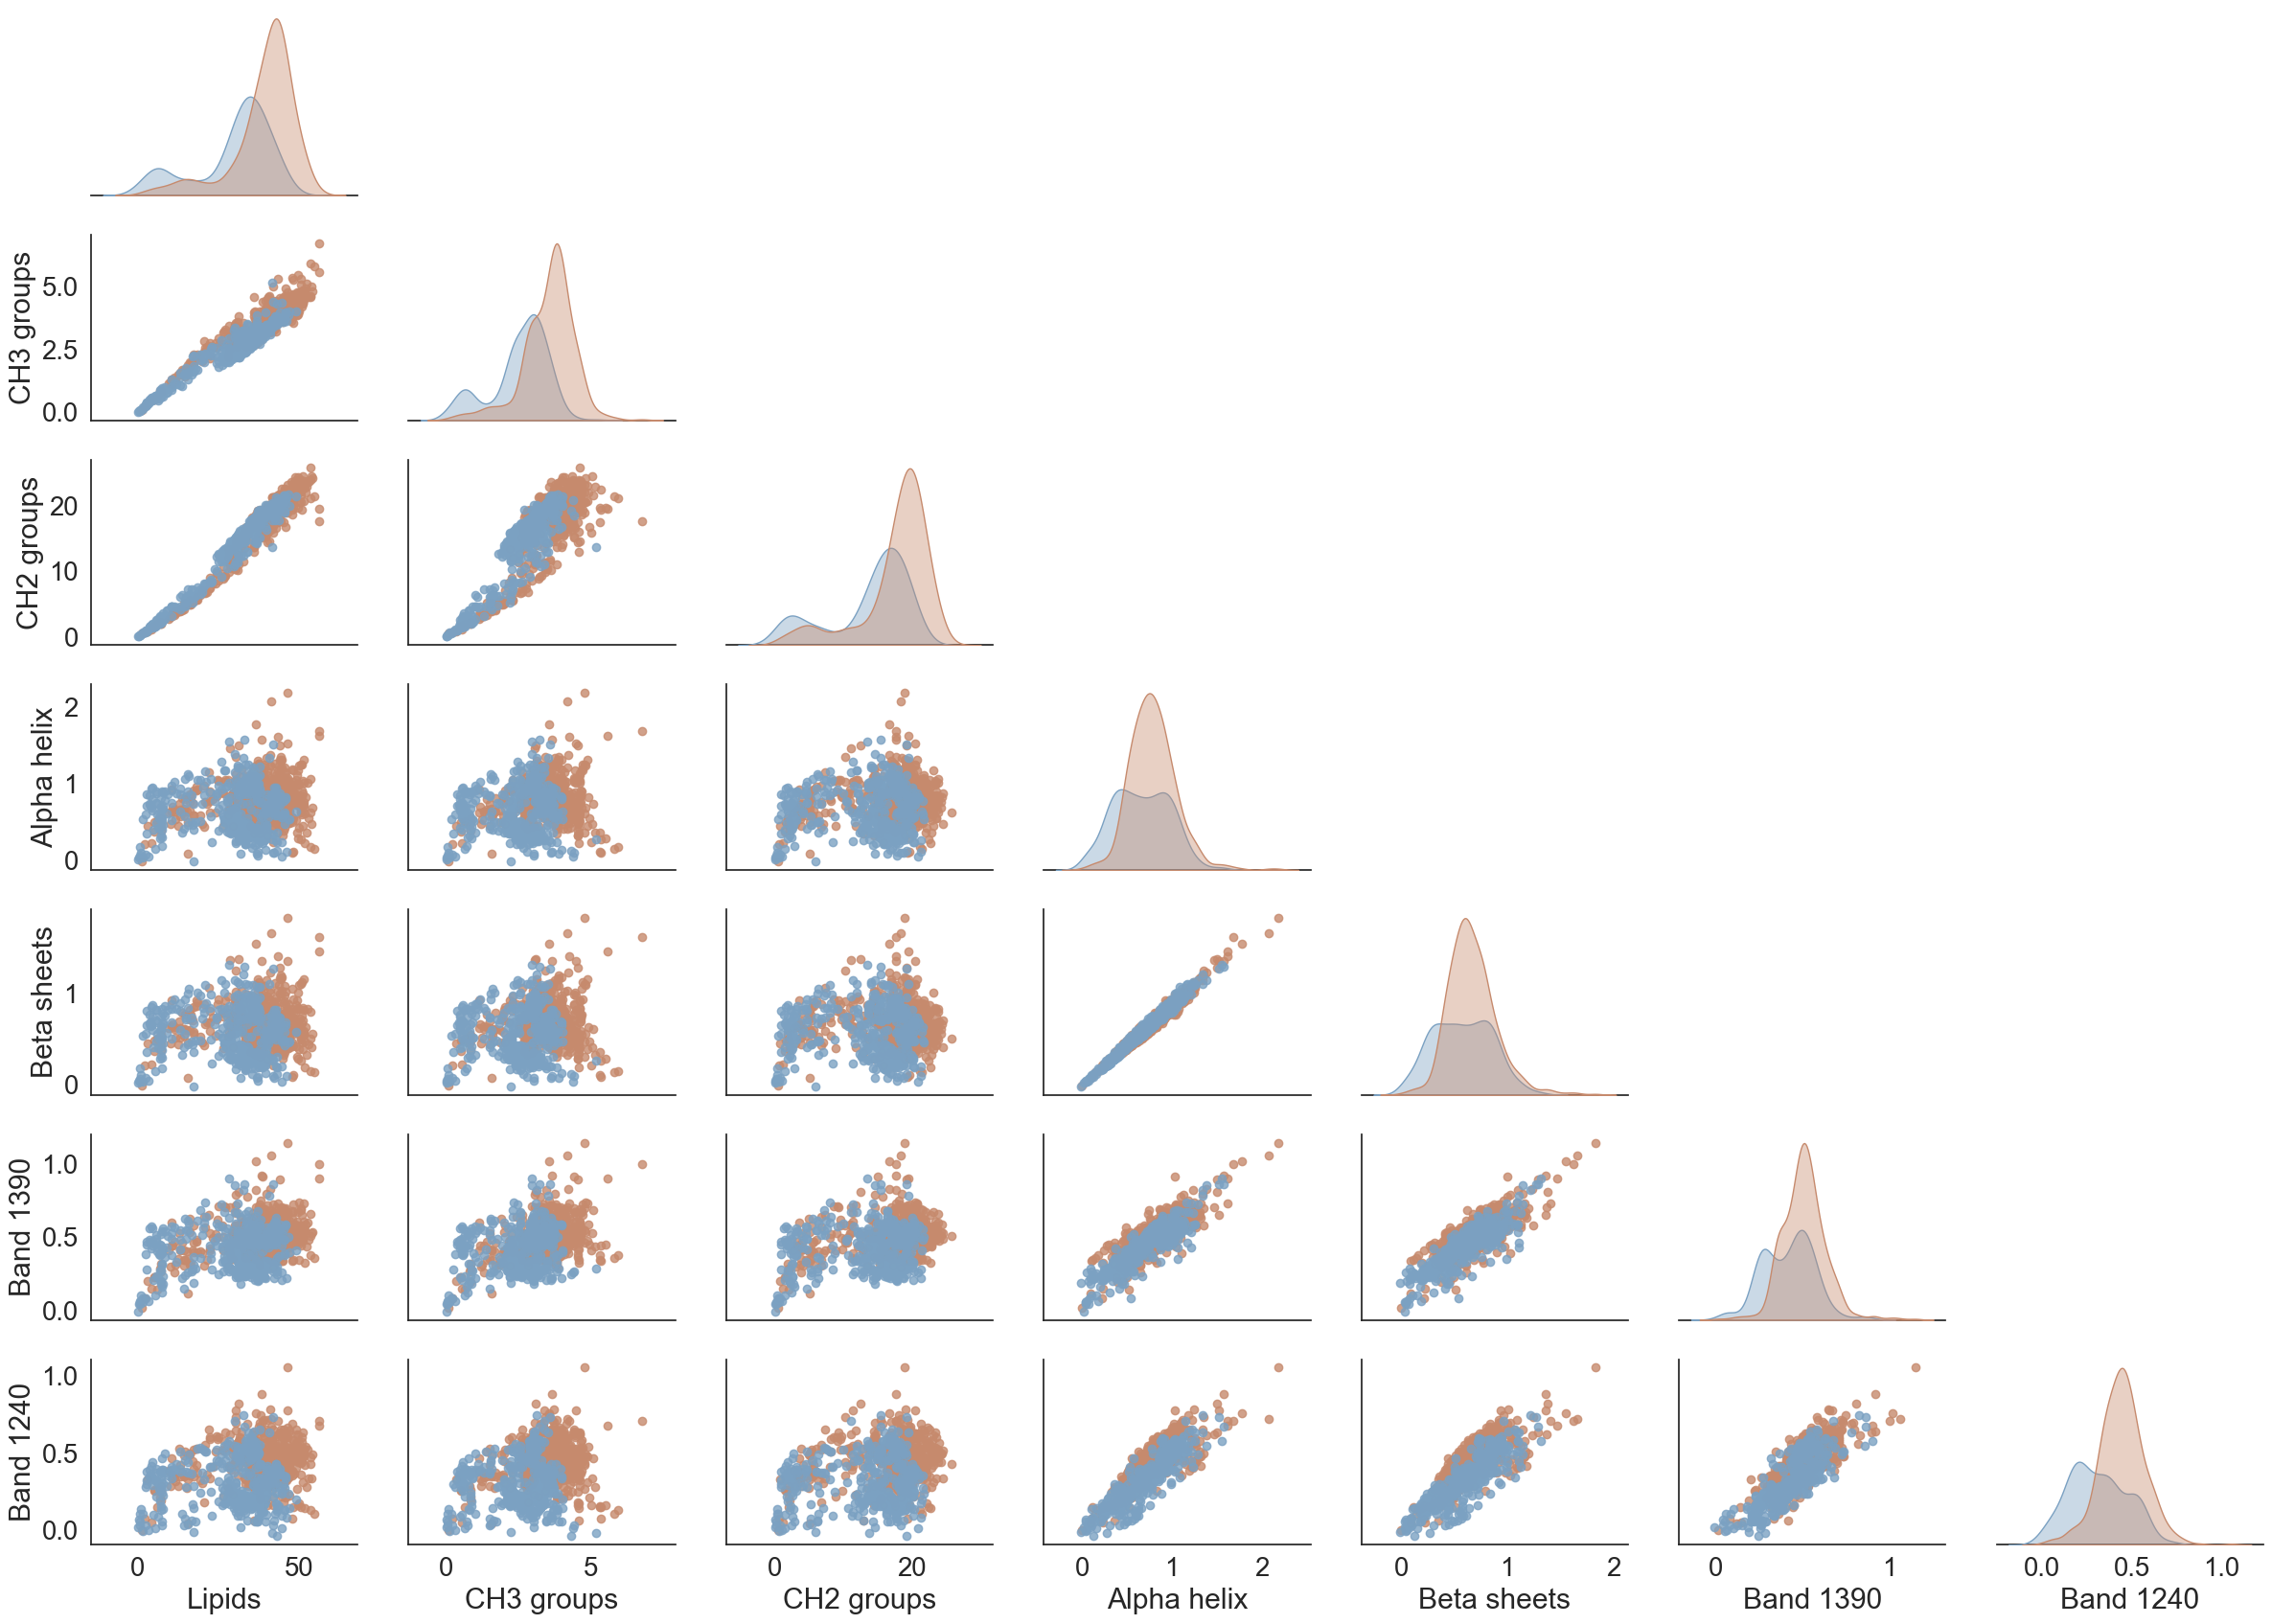

In [14]:
sns.set(style='white', font_scale=1.8)
g = sns.PairGrid(selected_columns.sample(1000), hue='Category', palette = 'twilight_shifted_r', aspect=1.4, diag_sharey=False, corner=True)
g.map_lower(plt.scatter, alpha=0.8)
g.map_diag(sns.kdeplot, alpha=0.4, fill=True)

From the scatter plots displayed above, it's evident that numerous variables exhibit correlations. This underscores the importance of treating the results post Bonferroni correction with caution, given the heightened risk of Type II errors.

## 2. Ratios calculation

### 2.A. Ratios calculation

Due to the explanation provided at the conclusion of section 1.A, further exploration of the data will be conducted after **replacing the original data with carefully chosen ratios**. These ratios were selected based on their meaningfulness, drawing from previous experience.

Let's define a function to facilitate the computation of ratios between specific spectral bands.

In [15]:
def to_ratios(df):
    """
    Calculates relevant ratios based on specific spectral bands and their sums (biomasses).
    
    Parameters:
    df (DataFrame): Input DataFrame containing spectral band and biomass data.
    
    Returns:
    DataFrame: DataFrame with calculated ratios.
    """
    df['Biomass I/Biomass II'] = df['Biomass_I']/df['Biomass_II']
    df['Amide III/Amide I'] = df['Band 1310']/df['Amide I']
    df['1080/1240'] = df['Band 1080']/df['Band 1240']
    df['1450/1390'] = df['Band 1450']/df['Band 1390']
    df['1080/Amide I'] = df['Band 1080']/df['Amide I']
    df['1240/Amide I'] = df['Band 1240']/df['Amide I']
    df['(1450+1390)/Lipids'] = (df['Band 1450']+df['Band 1390'])/df['Lipids']
    df['1450/Lipids'] = df['Band 1450']/df['Lipids']
    df['1390/Lipids'] = df['Band 1390']/df['Lipids']
    df['Amide B/Amide I'] = df['Band 3060']/df['Amide I']
    df['Amide III/Amide B'] = df['Band 1310']/df['Band 3060']
    df['CH3/1450'] = df['CH3 groups']/df['Band 1450']
    df['2850/1450'] = df['Band 2850']/df['Band 1450']
    
    # Drop unnecessary columns
    df.drop(['Lipids', 'Unsaturated lipids', 'CH3 groups', 'CH2 groups', 'Ester groups', 
             'Amide I','Alpha helix', 'Beta sheets', 'Beta turns',  
             'Band 1450', 'Band 1390', 'Band 1240', 'Band 1080', 'Band 1310', 
             'Band 2850', 'Band 3060', 'Biomass_I', 'Biomass_II', 'Biomass_Total'], 
            axis=1, inplace=True)
    
    return df

Let's modify the datasets accordingly and examine the resulting values.

In [16]:
train_PAR_patient_ratios = to_ratios(train_PAR_patient.copy())
train_PAR_patient_ratios.describe()

,Unsaturated/saturated lipid ratio,Lipid saturation,Carbonyl/lipid ratio,Lipid/protein ratio,Alpha helix/beta sheets,Percentage of beta forms,Biomass I/Biomass II,Amide III/Amide I,1080/1240,1450/1390,1080/Amide I,1240/Amide I,(1450+1390)/Lipids,1450/Lipids,1390/Lipids,Amide B/Amide I,Amide III/Amide B,CH3/1450,2850/1450
count,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000
mean,-0.008055,5.052958,-0.005236,8.512385,1.174691,61.847982,1.388561,0.006254,2.148800,3.075025,0.149955,0.073296,0.061728,0.043492,0.018237,0.013710,0.123354,2.230705,4.113176
std,0.171228,1.373080,0.171264,80.110904,0.086465,2.144395,1.151412,0.057392,8.747873,1.069224,0.679349,0.122583,0.812105,0.372746,0.441154,0.096567,29.880271,0.452574,1.046644
min,-20.574695,-12.500501,-9.467781,-3182.502180,-1.164337,15.902753,-24.500378,-1.283029,-872.406391,-15.758357,-19.822383,-8.179058,-44.278926,-20.511607,-23.767319,-4.500414,-3122.761291,-1.688143,-5.461221
25%,-0.006095,4.373478,-0.006580,4.702424,1.126454,60.627447,1.171459,0.003446,1.231247,2.499478,0.086733,0.060334,0.045452,0.034283,0.010633,0.012600,0.181742,2.067559,3.634582
50%,-0.005166,5.284103,-0.004674,6.288154,1.187930,61.470987,1.415675,0.005443,1.405182,2.957262,0.103916,0.068906,0.050242,0.037376,0.012950,0.015044,0.354630,2.316895,4.404072
75%,-0.004580,5.814490,-0.003594,8.575766,1.227840,62.812611,1.598891,0.007393,1.861613,3.506426,0.152531,0.078535,0.061013,0.044781,0.016266,0.017399,0.488574,2.494128,4.827392
max,1.315750,100.891181,17.282730,4662.804150,4.740361,163.059435,93.322093,3.704694,273.001404,11.780412,66.985405,5.532016,79.450405,35.189751,44.260655,4.955650,681.924812,18.795544,27.815570


In [17]:
train_DEP_patient_ratios = to_ratios(train_DEP_patient.copy())
train_DEP_patient_ratios.describe()

,Unsaturated/saturated lipid ratio,Lipid saturation,Carbonyl/lipid ratio,Lipid/protein ratio,Alpha helix/beta sheets,Percentage of beta forms,Biomass I/Biomass II,Amide III/Amide I,1080/1240,1450/1390,1080/Amide I,1240/Amide I,(1450+1390)/Lipids,1450/Lipids,1390/Lipids,Amide B/Amide I,Amide III/Amide B,CH3/1450,2850/1450
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,-0.022774,2.304119,-0.067685,0.365538,1.094756,62.399289,0.844961,0.002536,1.793138,0.693966,0.106621,0.070015,0.275938,0.111566,0.164373,0.020217,0.083865,1.972626,1.215309
std,0.088712,1.103205,0.100883,0.262588,0.117663,26.347070,0.484552,0.024661,12.263690,0.416207,0.128979,0.108648,0.321829,0.141946,0.191338,0.013926,2.700515,10.421656,12.668149
min,-1.974823,-21.326547,-3.310213,-5.836347,-4.372162,-24.031765,-10.213844,-1.765269,-306.487506,-15.730013,-6.318762,-0.628035,-14.296027,-8.227910,-9.650421,-0.471952,-198.698113,-79.702397,-46.356688
25%,-0.025959,1.933440,-0.088212,0.280773,1.022329,60.575284,0.765867,0.001014,1.241513,0.609571,0.079768,0.059919,0.234991,0.093953,0.137804,0.018780,0.048461,1.524542,0.671357
50%,-0.023316,2.156301,-0.070912,0.327555,1.103970,61.483593,0.903578,0.003239,1.380860,0.683980,0.092615,0.066169,0.276545,0.107796,0.164077,0.020049,0.164675,1.798743,0.869460
75%,-0.020752,2.548757,-0.055162,0.395779,1.168299,63.188287,0.972503,0.004927,1.597655,0.764936,0.113250,0.072358,0.316894,0.127766,0.190693,0.021986,0.257372,1.950856,1.160636
max,3.663749,52.807238,4.013944,11.318112,3.623075,2130.251724,20.226378,0.648670,647.511123,13.599328,2.449182,8.051948,9.709421,3.261416,6.448005,0.449613,13.024380,617.696146,936.580640


The conversion to ratios above didn't encounter any issues such as division by zero. However, dividing by very small values led to numerous outliers.

Let's visualize the data using histograms and compare two approaches for **detecting outliers**: the **Z-score** method and the **Interquartile Range (IQR)** method.

In [18]:
def outliers_lim_IQR(df, n=1.5):
    """
    Finds limit values for outliers using the Interquartile Range (IQR) method.
    
    Parameters:
    df (DataFrame): Input DataFrame containing numerical data.
    n (float): Scaling factor to adjust the range of acceptable values (default is 1.5).

    Returns:
    tuple: Lower and upper limit values for outliers.
    """
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - n * IQR
    upper_lim = Q3 + n * IQR
    return lower_lim, upper_lim

In [19]:
def outliers_lim_zscore(df, n=2):
    """
    Finds limits of inliers with the z-score method.
    
    Parameters:
    v (array-like): Input array of numerical values.
    n (float): Scaling factor to adjust the range of acceptable values (default is 2).

    Returns:
    tuple: Lower and upper limit values for outliers.
    """
    mean = np.mean(df)
    std = np.std(df)
    lower_lim = mean - n * std
    upper_lim = mean + n * std
    return lower_lim, upper_lim

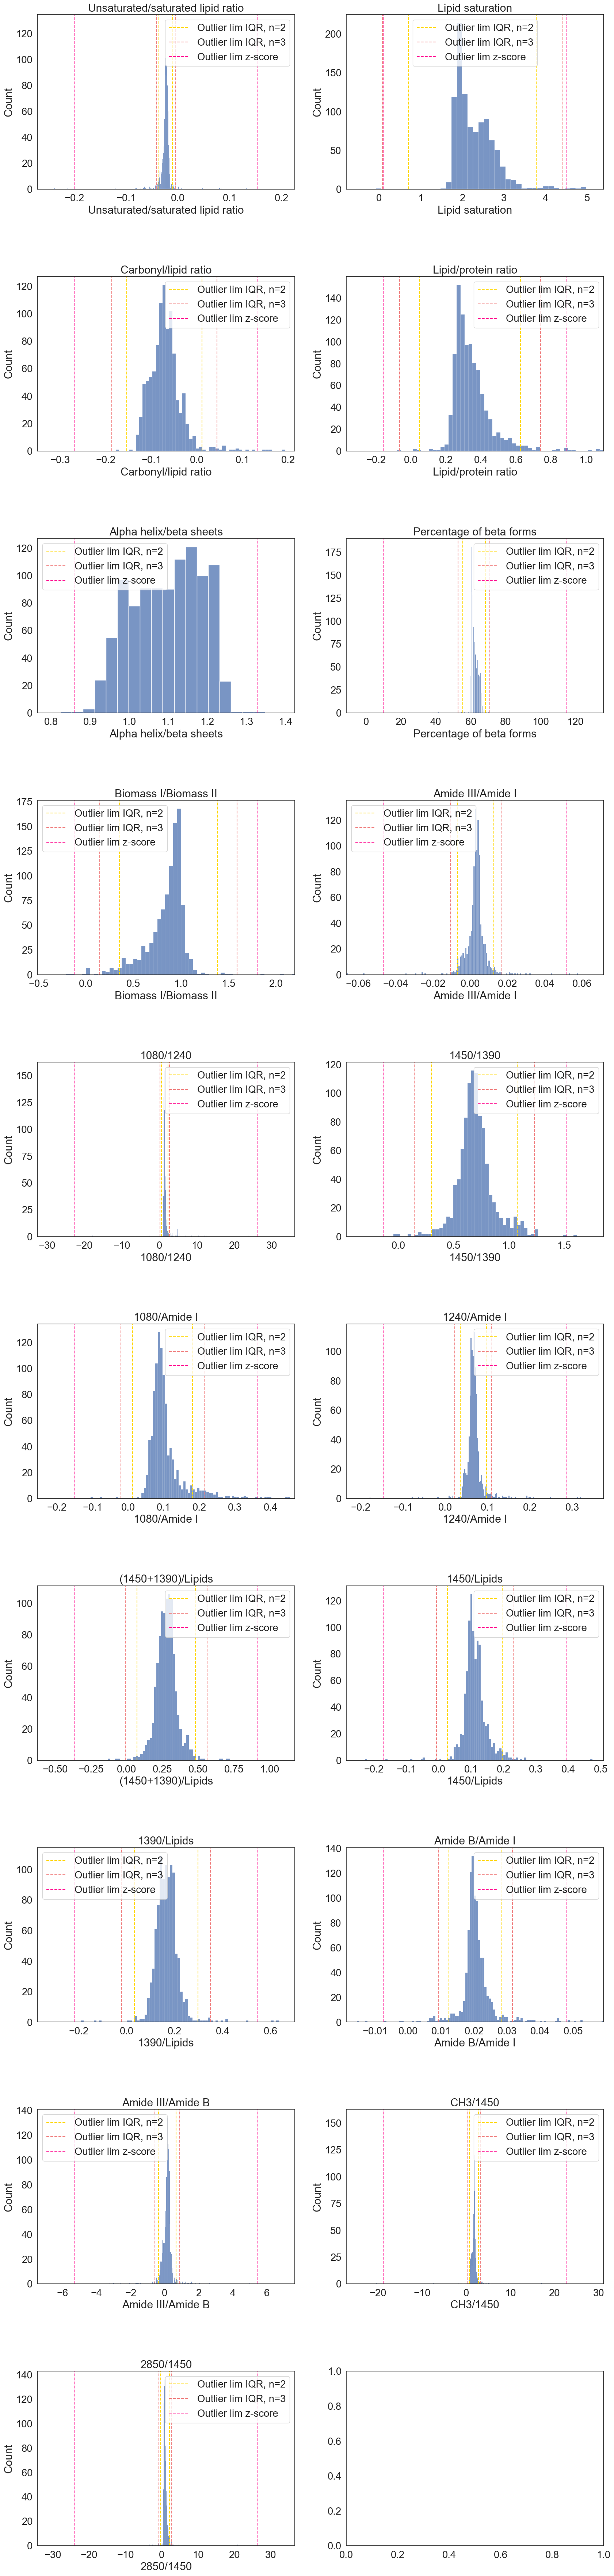

In [20]:
# Selecting numeric columns
num_cols = train_DEP_patient_ratios.select_dtypes(include=[np.number]).columns

# Calculating the number of plots and rows required for the subplot grid
num_plots = len(num_cols)
num_rows = (num_plots + 1) // 2

# Creating a figure and subplot grid
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(20, 9*num_rows))
fig.subplots_adjust(hspace=0.5)

# Iterating over each numeric column
for idx, col in enumerate(num_cols):
    # Calculating the row and column number for the current subplot
    row = idx // 2
    col_num = idx % 2
    ax = axes[row, col_num]

    # Setting the title of the subplot as the column name
    ax.set_title(col)

    # Plotting the histogram of the current column
    sns.histplot(train_DEP_patient_ratios.sample(1000), x=col, ax=ax)

    # Calculating outlier limits using the Interquartile Range (IQR) method with different scaling factors
    out0 = outliers_lim_IQR(train_DEP_patient_ratios[col], n=2)
    outl = outliers_lim_IQR(train_DEP_patient_ratios[col], n=3)
    
    # Calculating outlier limits using the Z-score method
    out2 = outliers_lim_zscore(train_DEP_patient_ratios[col])

    # Adding vertical lines to indicate outlier limits and providing labels for different methods
    ax.axvline(x=out0[0], color='gold', linestyle='--', label='Outlier lim IQR, n=2')
    ax.axvline(x=out0[1], color='gold', linestyle='--')
    ax.axvline(x=outl[0], color='lightcoral', linestyle='--', label='Outlier lim IQR, n=3')
    ax.axvline(x=outl[1], color='lightcoral', linestyle='--')
    ax.axvline(x=out2[0], color='deeppink', linestyle='--', label='Outlier lim z-score')
    ax.axvline(x=out2[1], color='deeppink', linestyle='--')

    # Adding a legend to the subplot
    ax.legend()

    # Adjusting the x-axis limits for better visualization
    ax.set_xlim([1.2 * out2[0] - 0.2 * out2[1], 1.2 * out2[1] - 0.2 * out2[0]])

# Displaying the subplots
plt.show()

After reviewing the plots above, I've determined that the **most optimal outcomes occur when using the Interquartile Range (IQR) with a factor of 3 for outlier detection**.

Instead of removing the outliers, I opted to winsorize them because deleting them could result in losing a significant amount of data, considering there are 19 variables, each potentially containing outliers. It's not very probable that the original data have erronous entries, given that the spectra were generated using a well-established algorithm. Therefore, I prefer to believe that the extreme ratios are genuine and chose to **winsorize them to the nearest inlier** to retain some of this information.

In [21]:
def winsorize_outliers(df, limits):
    """
    Winsorizes outliers in numeric columns of the given dataset.
    
    Parameters:
    df (DataFrame): Input DataFrame containing numerical data.
    limits (tuple): Tuple of lower and upper limit values for winsorization.

    Returns:
    DataFrame: DataFrame with outliers winsorized in the specified columns.
    """
    low, upp = limits
    cols = df.select_dtypes(include=np.number).columns.tolist()
    for col in cols:
        # Find the percentiles corresponding to the lower and upper limits obtained with IQR
        percentile_low = stats.percentileofscore(df[col], low[col]) / 100
        percentile_upp = 1 - stats.percentileofscore(df[col], upp[col]) / 100
        
        # Winsorize the data accordingly
        df[col] = stats.mstats.winsorize(df[col], limits=[percentile_low, percentile_upp])
    return df

Let's apply winsorization to handle outliers in both the paraffin-embedded and deparaffinized datasets.

In [22]:
# Extracting numeric values from the DataFrame
train_PAR_patient_num = train_PAR_patient_ratios.select_dtypes(include='number')
# Winsorizing outliers using the IQR method
train_PAR_patient_win = winsorize_outliers(train_PAR_patient_ratios, outliers_lim_IQR(train_PAR_patient_num, n=3))

In [23]:
# Extracting numeric values from the DataFrame
train_DEP_patient_num = train_DEP_patient_ratios.select_dtypes(include='number')
# Winsorizing outliers using the IQR method
train_DEP_patient_win = winsorize_outliers(train_DEP_patient_ratios, outliers_lim_IQR(train_DEP_patient_num, n=3))

### 2.B. Understanding the new variables

By computing **ratios**, we have **mitigated the issue of insufficient normalization in the results**. Additionally, this **enhances the model's adaptability regarding spectral preprocessing for future applications**.

Now, let's ascertain whether computing these ratios has compromised our ability to differentiate between HGSC and MUC samples.

In [24]:
# Statistically significant changes for paraffine samples
significant_difference, no_significant_difference = compare_categories(train_PAR_patient_win, 0.05)
print("\033[1mPARAFFINE SAMPLES. Columns with significant difference after Bonferroni correction:\033[0m", significant_difference,'\n')
print("\033[1mDEPARAFFINIZED SAMPLES. Columns with no significant difference after Bonferroni correction:\033[0m", no_significant_difference)

PARAFFINE SAMPLES. Columns with significant difference after Bonferroni correction: ['Lipid saturation', 'Carbonyl/lipid ratio', 'Lipid/protein ratio', 'Alpha helix/beta sheets', 'Percentage of beta forms', 'Biomass I/Biomass II', 'Amide III/Amide I', '1080/1240', '1450/1390', '1080/Amide I', '1240/Amide I', '(1450+1390)/Lipids', '1450/Lipids', '1390/Lipids', 'Amide B/Amide I', 'Amide III/Amide B', 'CH3/1450', '2850/1450'] 

DEPARAFFINIZED SAMPLES. Columns with no significant difference after Bonferroni correction: ['Unsaturated/saturated lipid ratio']


In [25]:
# Statistically significant changes for deparaffinized samples
significant_difference, no_significant_difference = compare_categories(train_DEP_patient_win, 0.05)
print("\033[1mPARAFFINE SAMPLES. Columns with significant difference after Bonferroni correction:\033[0m", significant_difference,'\n')
print("\033[1mDEPARAFFINIZED SAMPLES. Columns with no significant difference after Bonferroni correction:\033[0m", no_significant_difference)

PARAFFINE SAMPLES. Columns with significant difference after Bonferroni correction: ['Unsaturated/saturated lipid ratio', 'Lipid saturation', 'Carbonyl/lipid ratio', 'Lipid/protein ratio', 'Percentage of beta forms', 'Biomass I/Biomass II', 'Amide III/Amide I', '1080/1240', '1450/1390', '1080/Amide I', '(1450+1390)/Lipids', '1450/Lipids', '1390/Lipids', 'Amide B/Amide I', 'Amide III/Amide B', '2850/1450'] 

DEPARAFFINIZED SAMPLES. Columns with no significant difference after Bonferroni correction: ['Alpha helix/beta sheets', '1240/Amide I', 'CH3/1450']


The proportion of variables exhibiting significant differences between HGSC and MUC samples remains consistent after ratio calculation. Next, let's delve into the distribution of values for both paraffin-embedded and deparaffinized samples.

Unsaturated/saturated lipid ratio


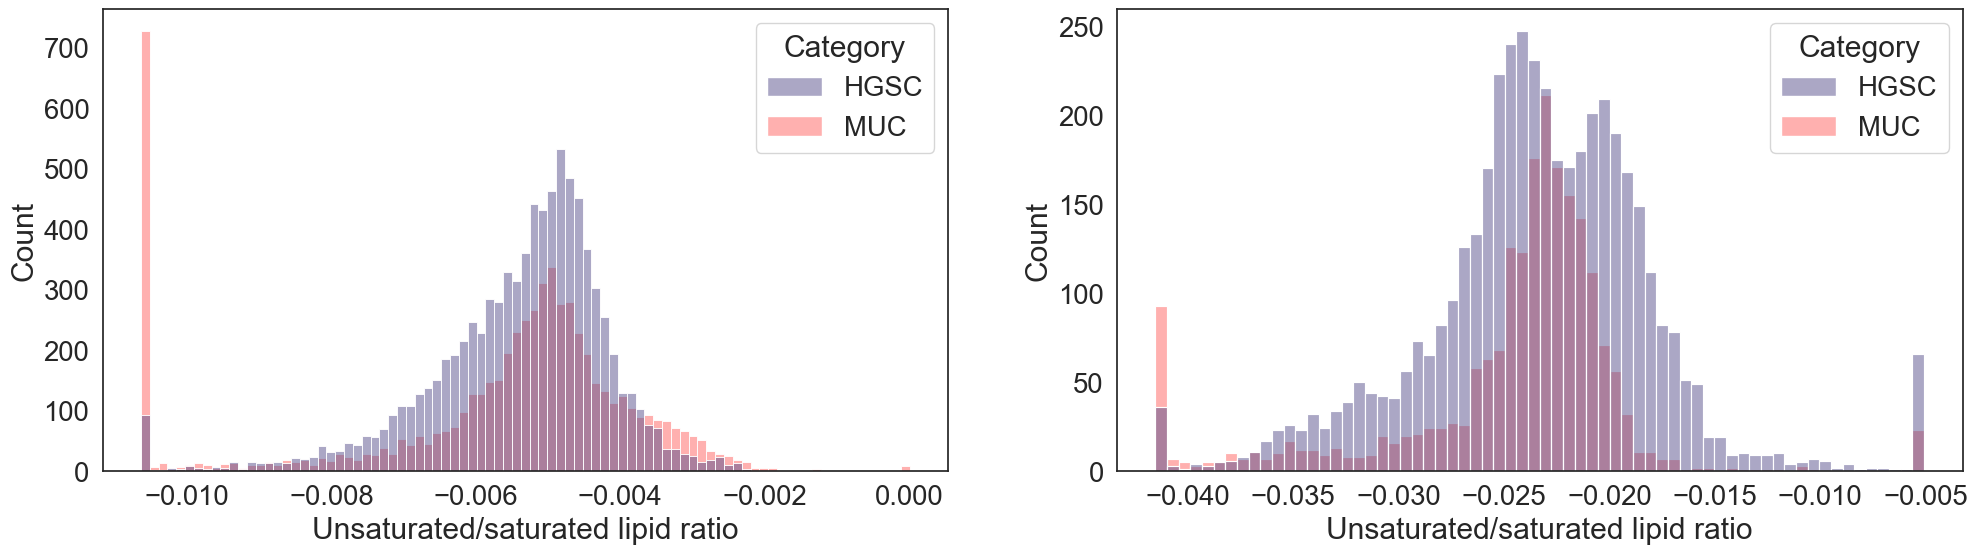

Lipid saturation


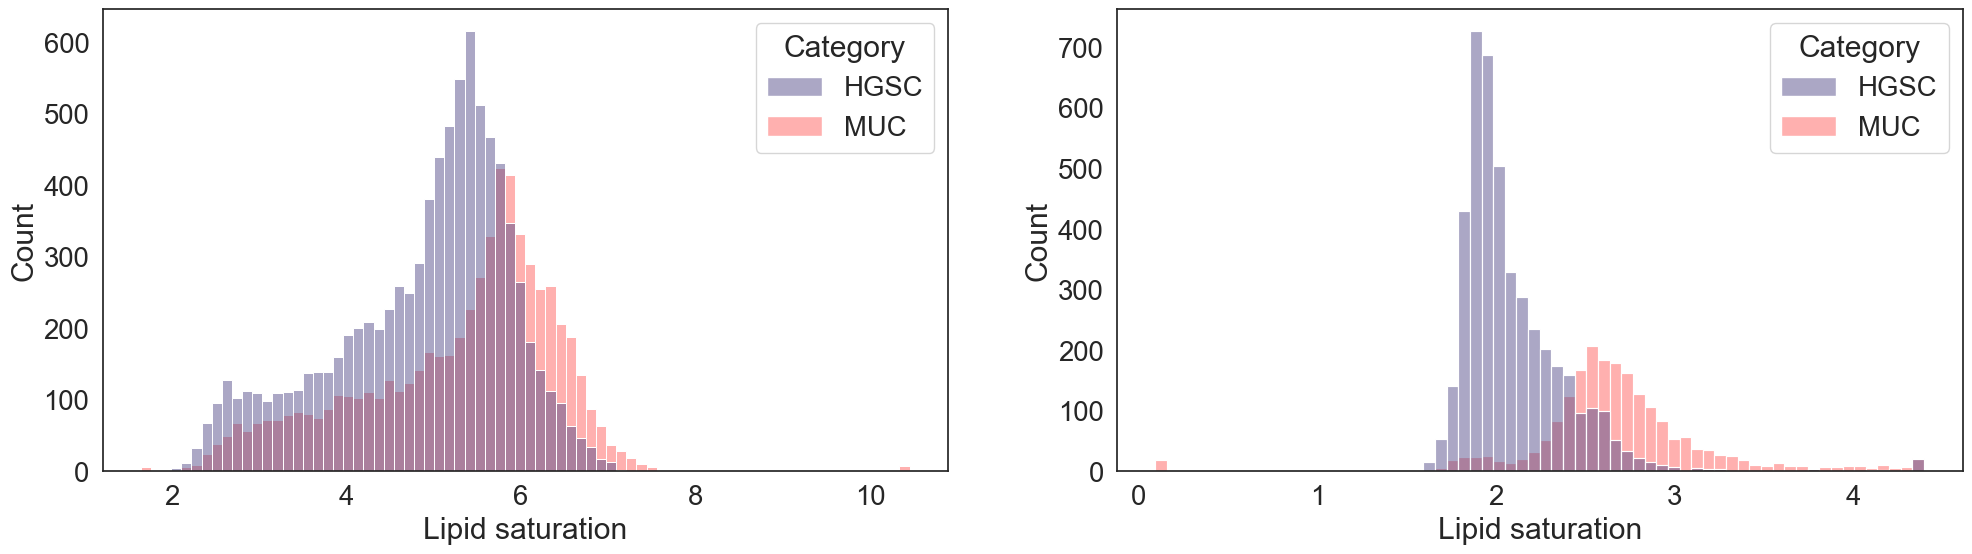

Carbonyl/lipid ratio


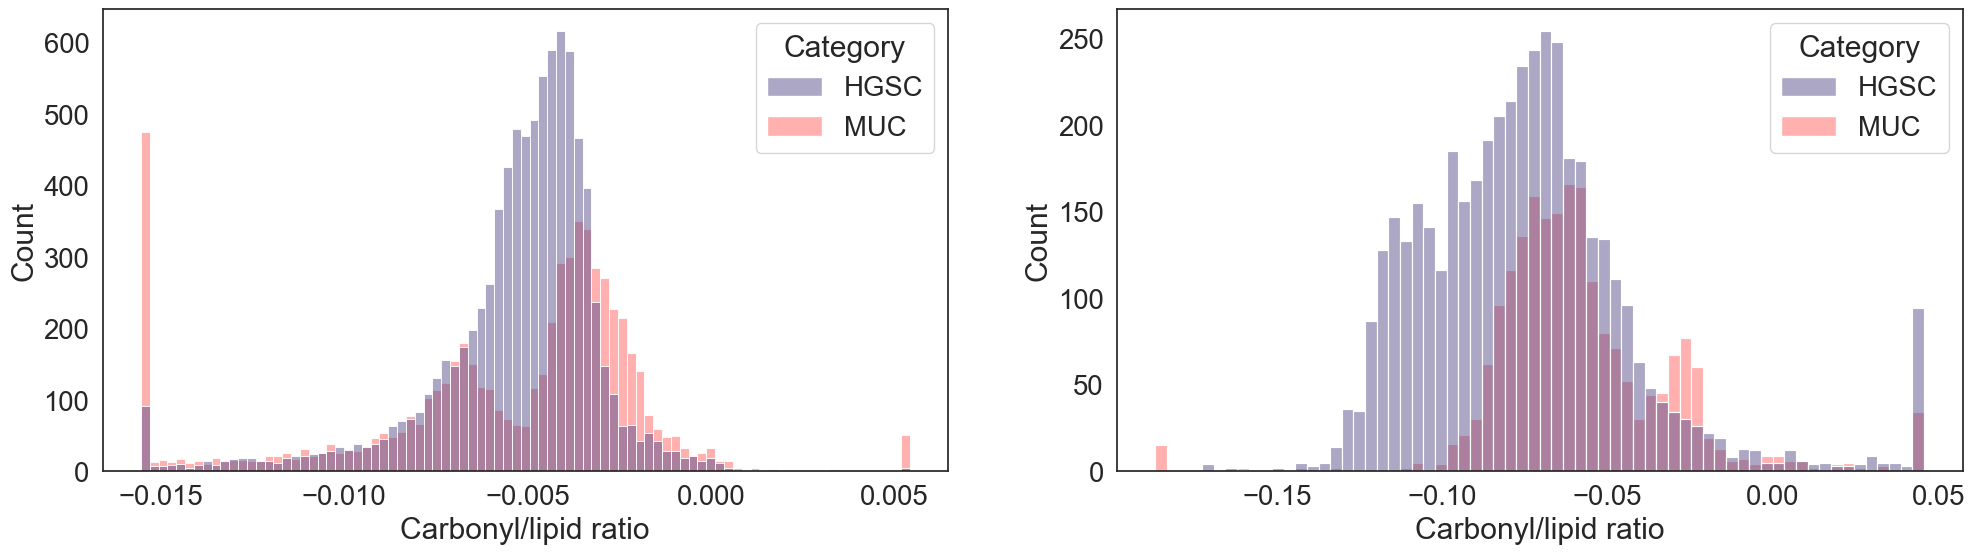

Lipid/protein ratio


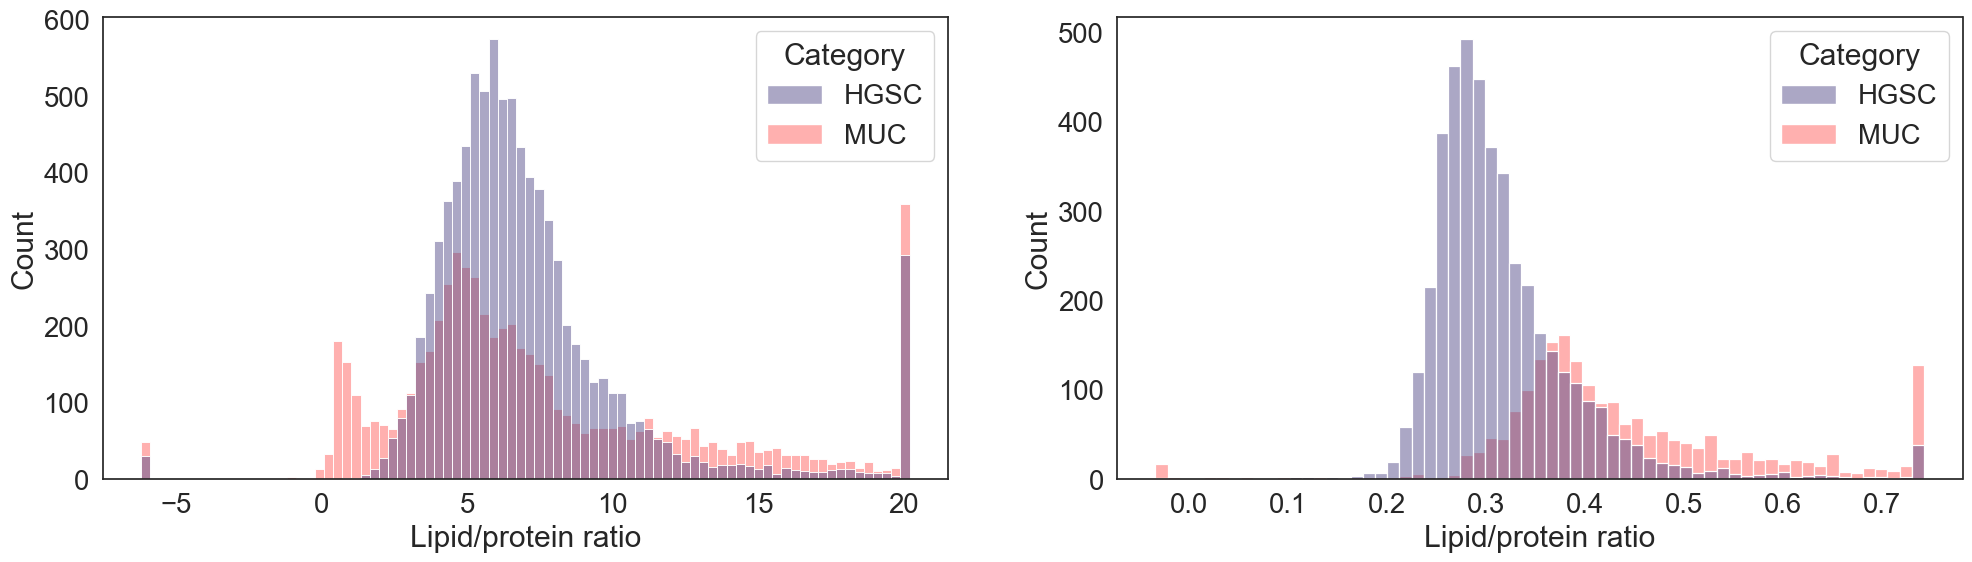

Alpha helix/beta sheets


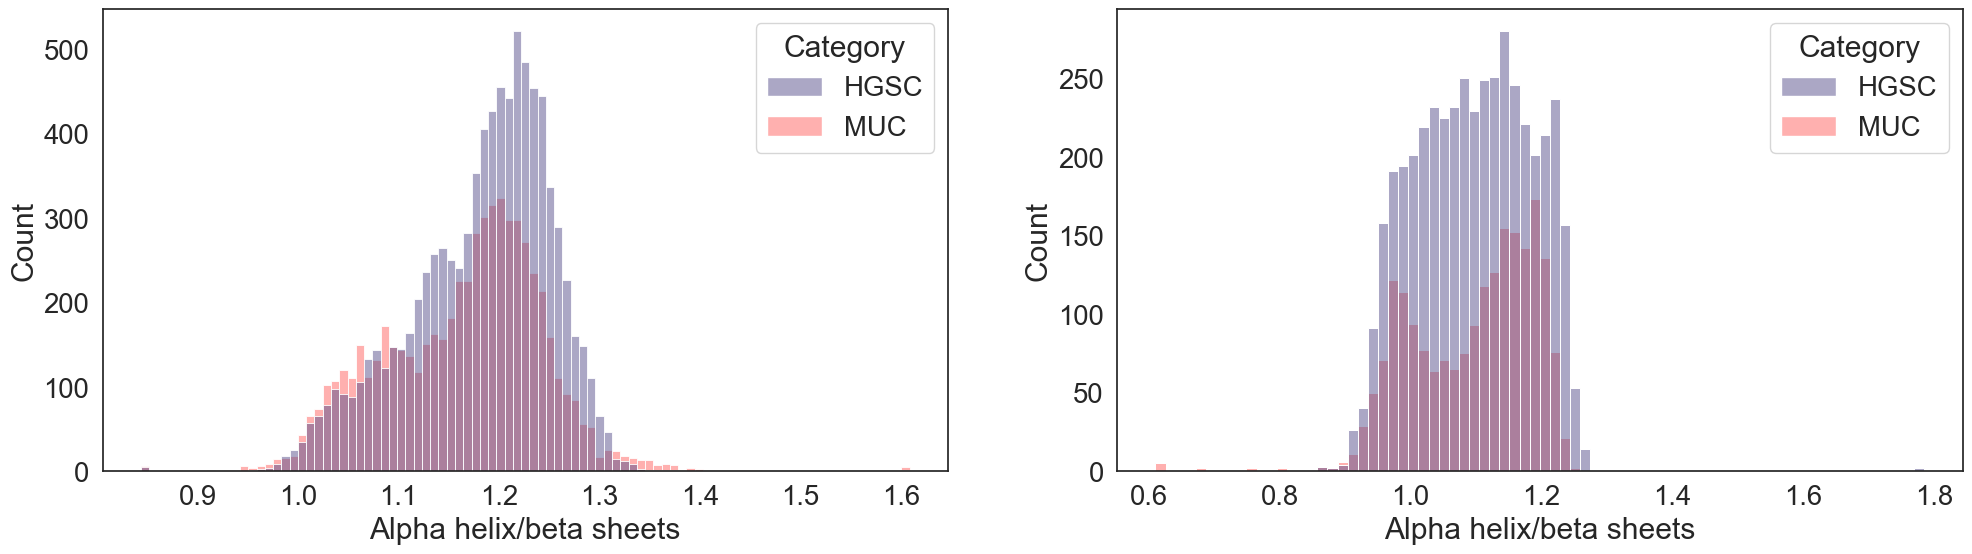

Percentage of beta forms


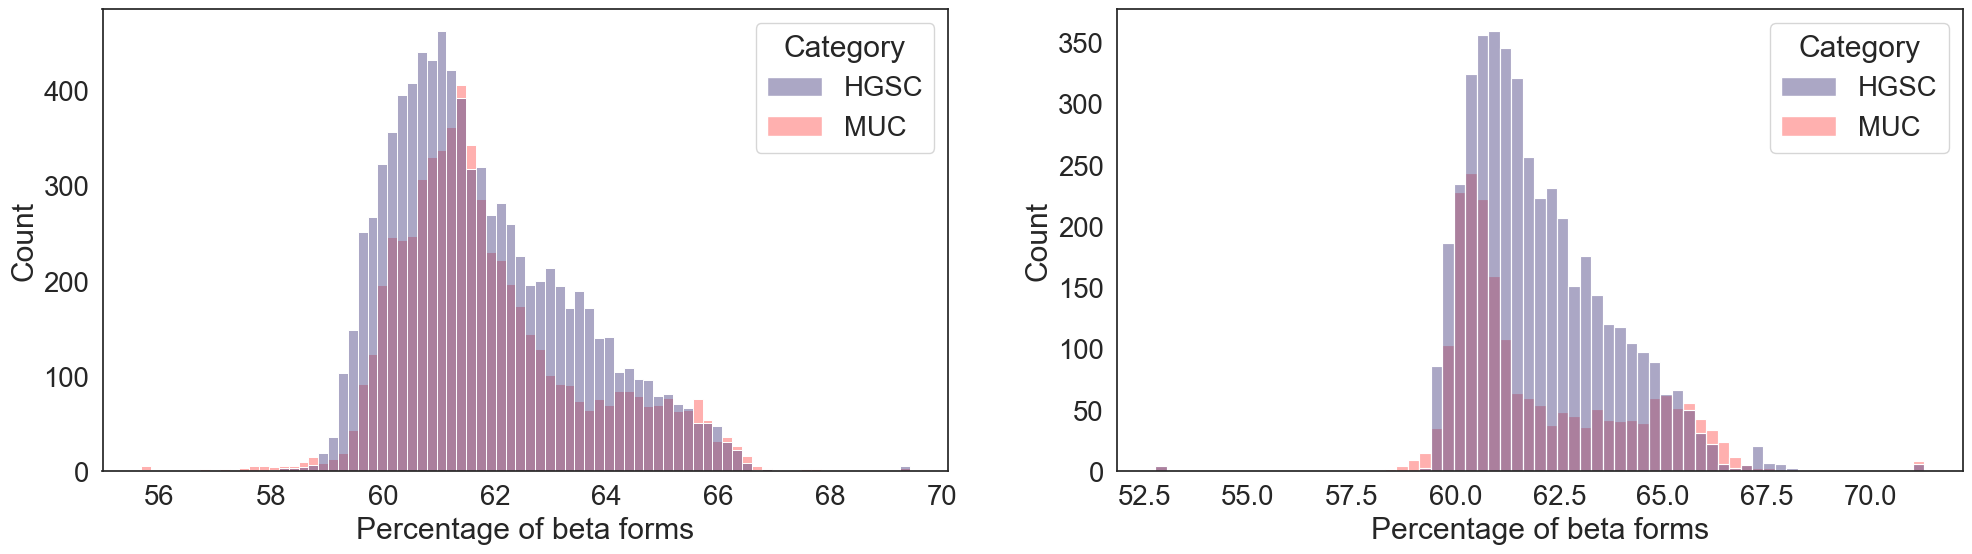

Biomass I/Biomass II


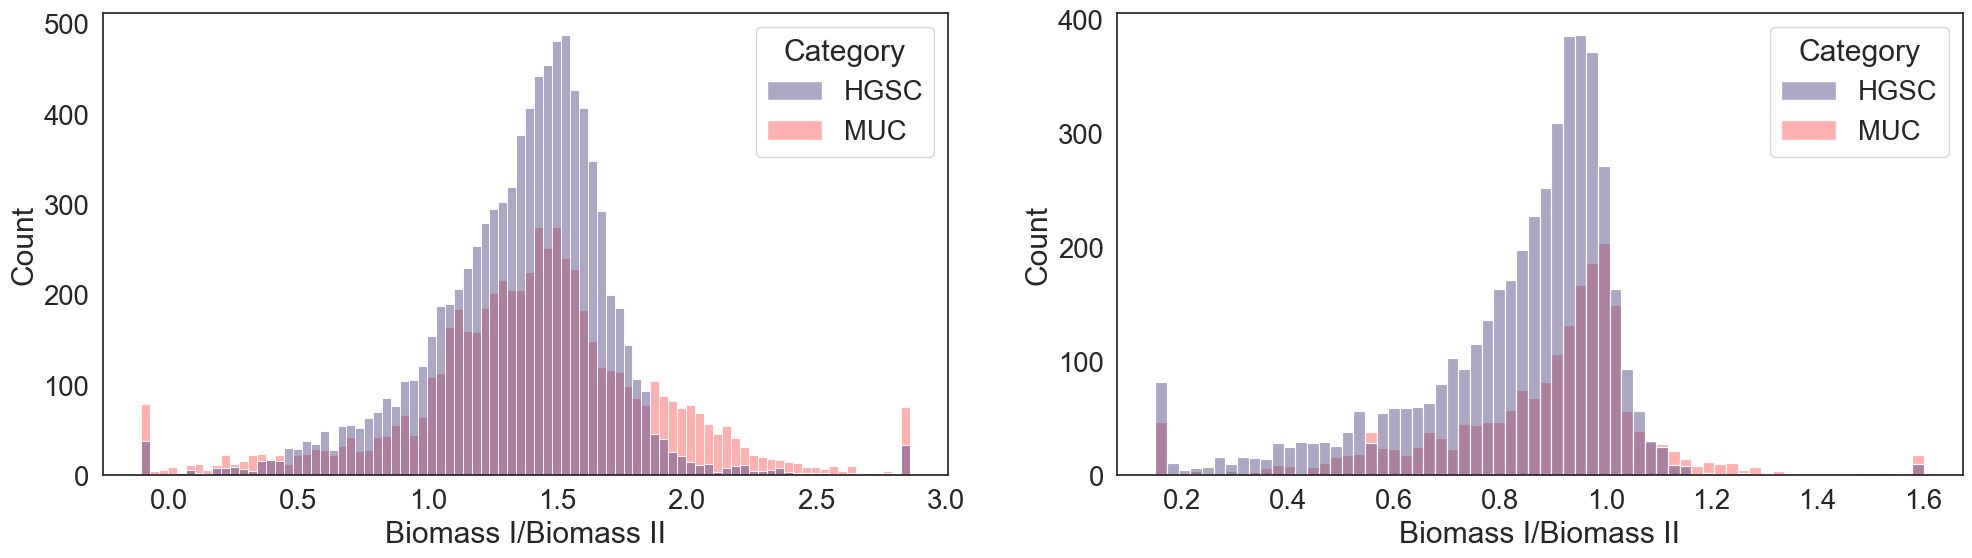

Amide III/Amide I


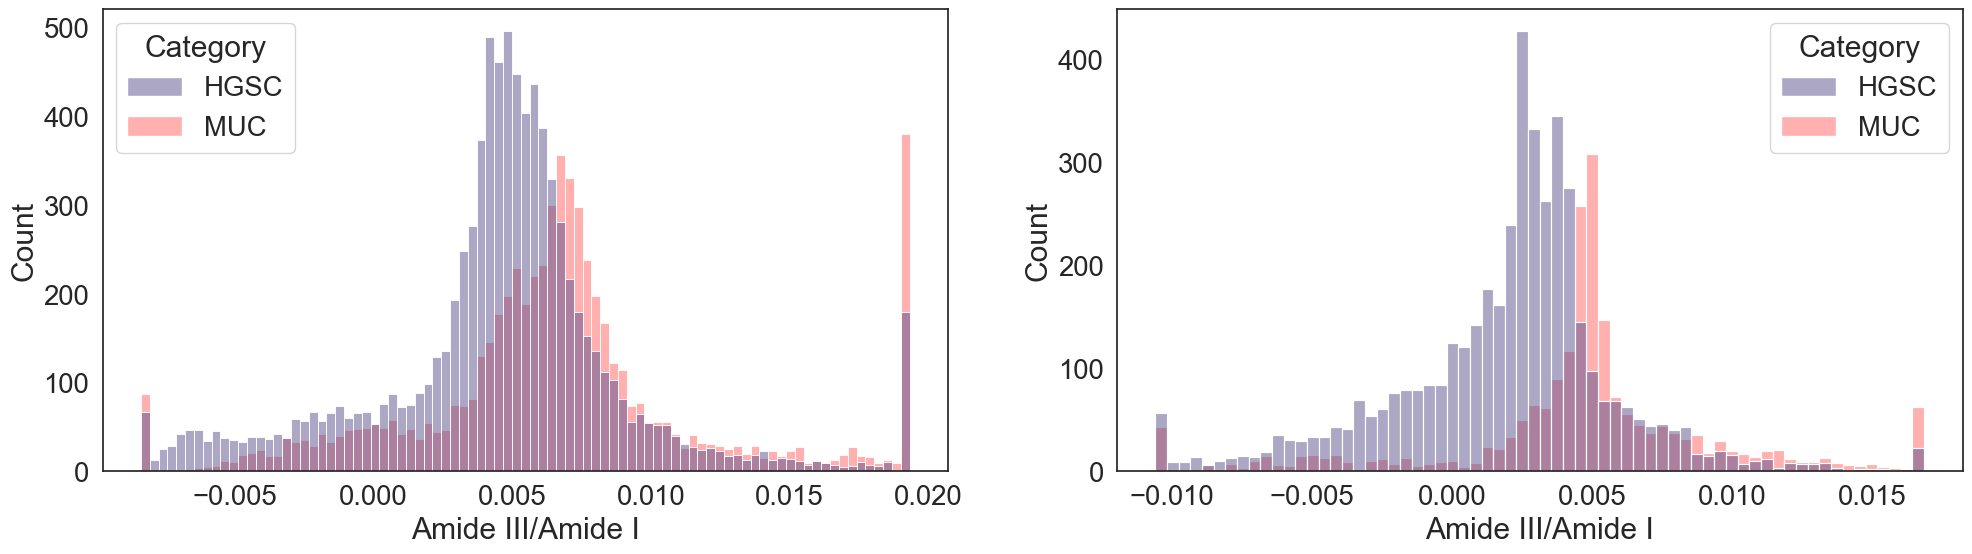

1080/1240


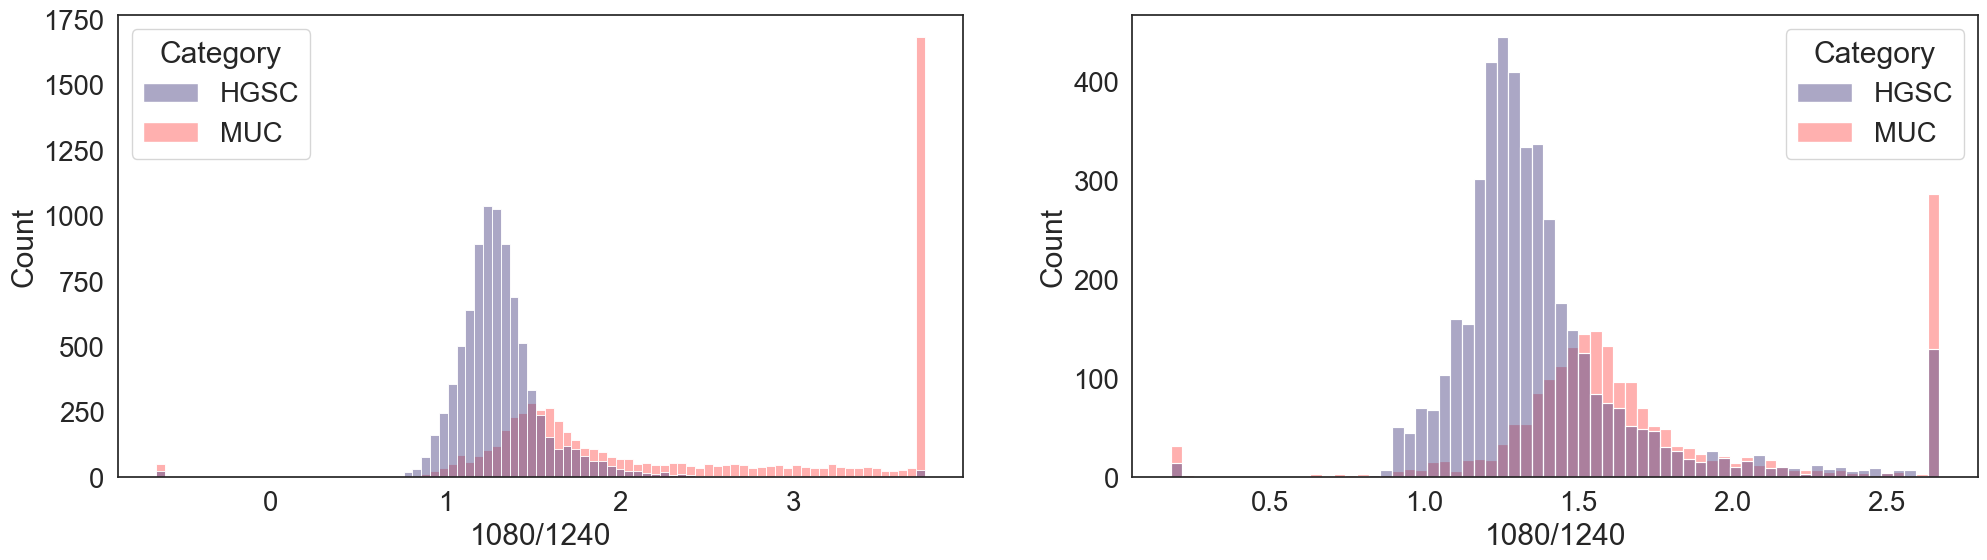

1450/1390


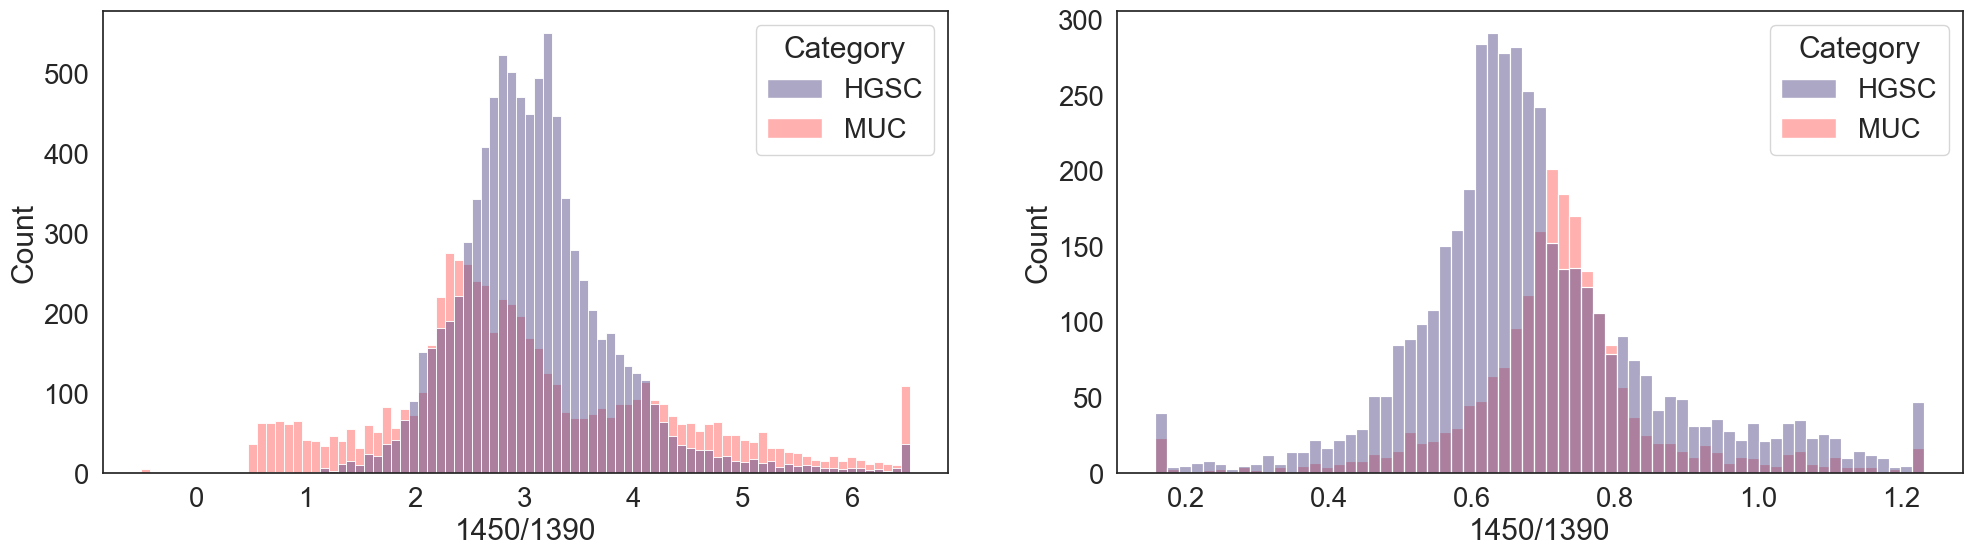

1080/Amide I


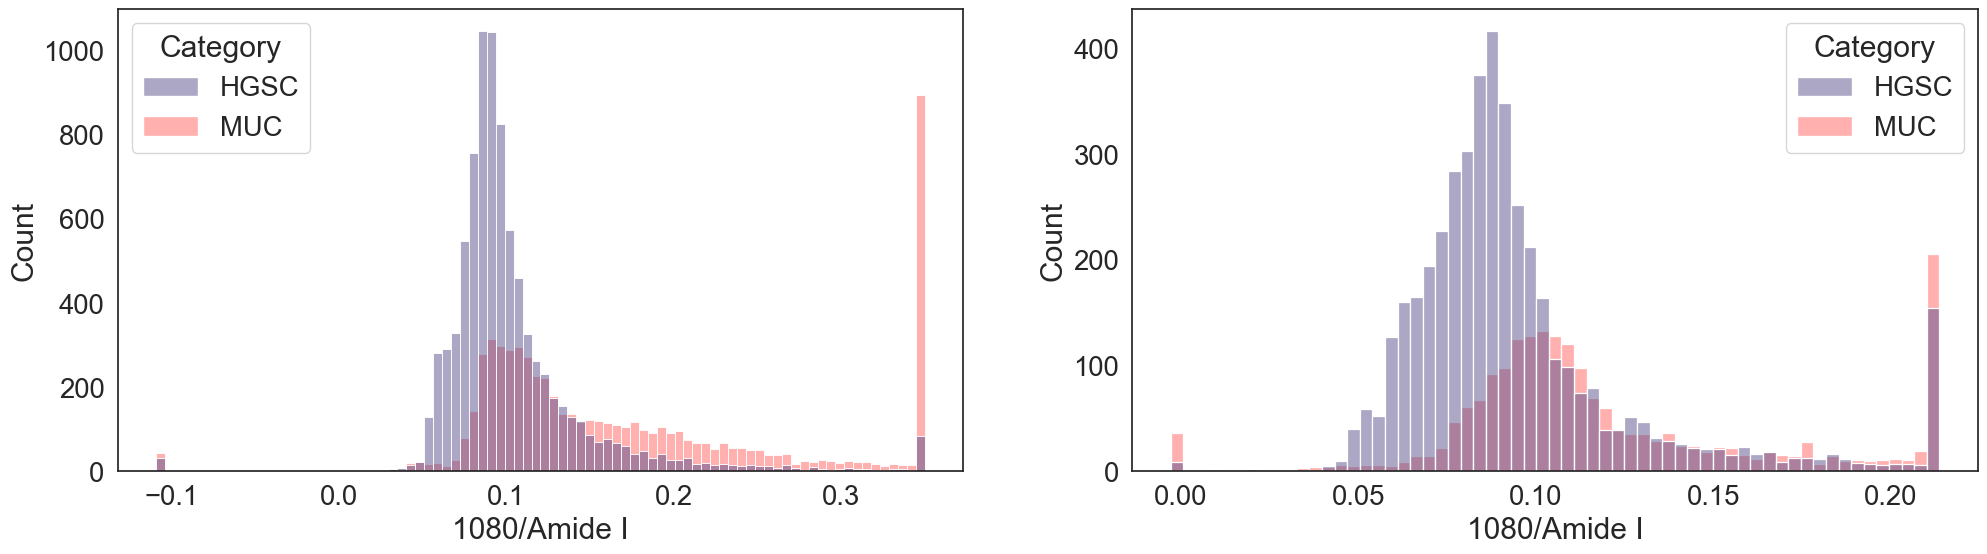

1240/Amide I


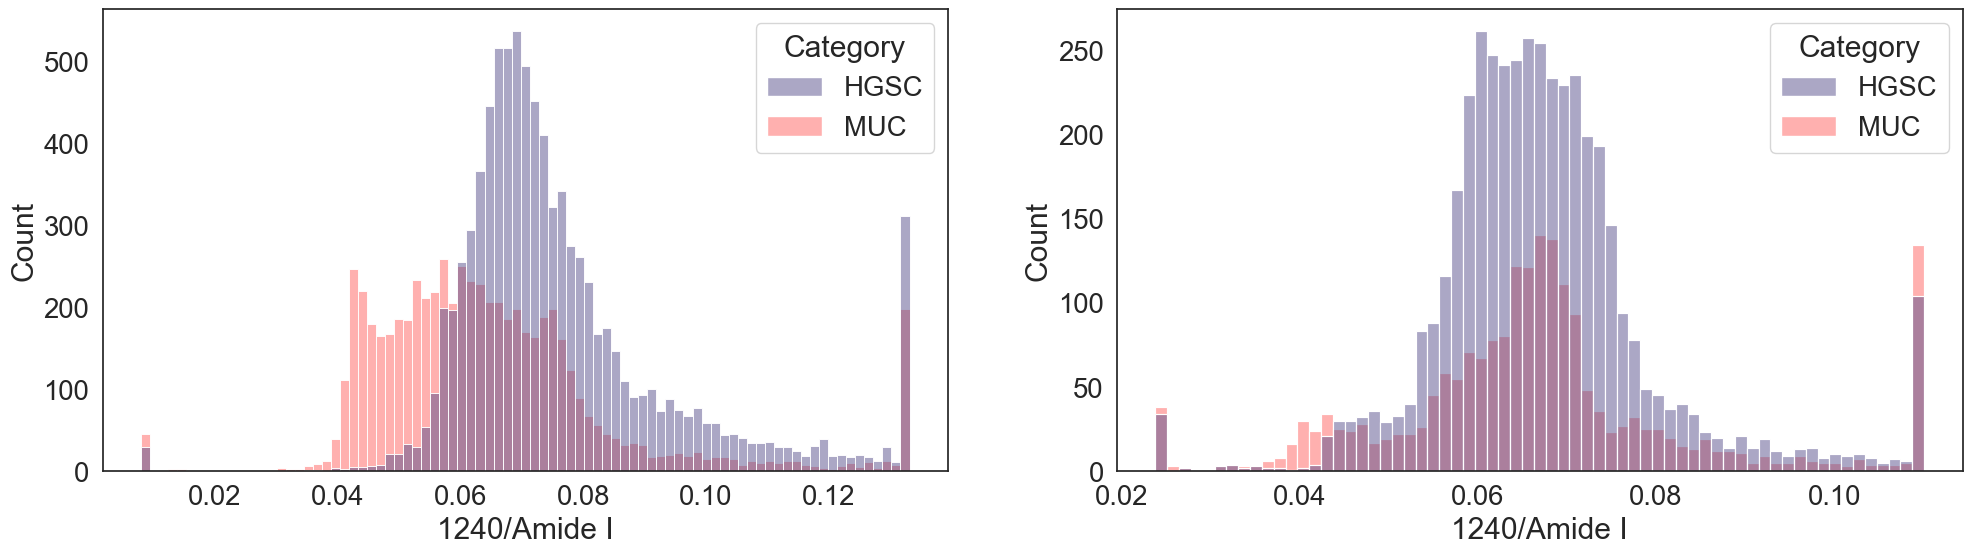

(1450+1390)/Lipids


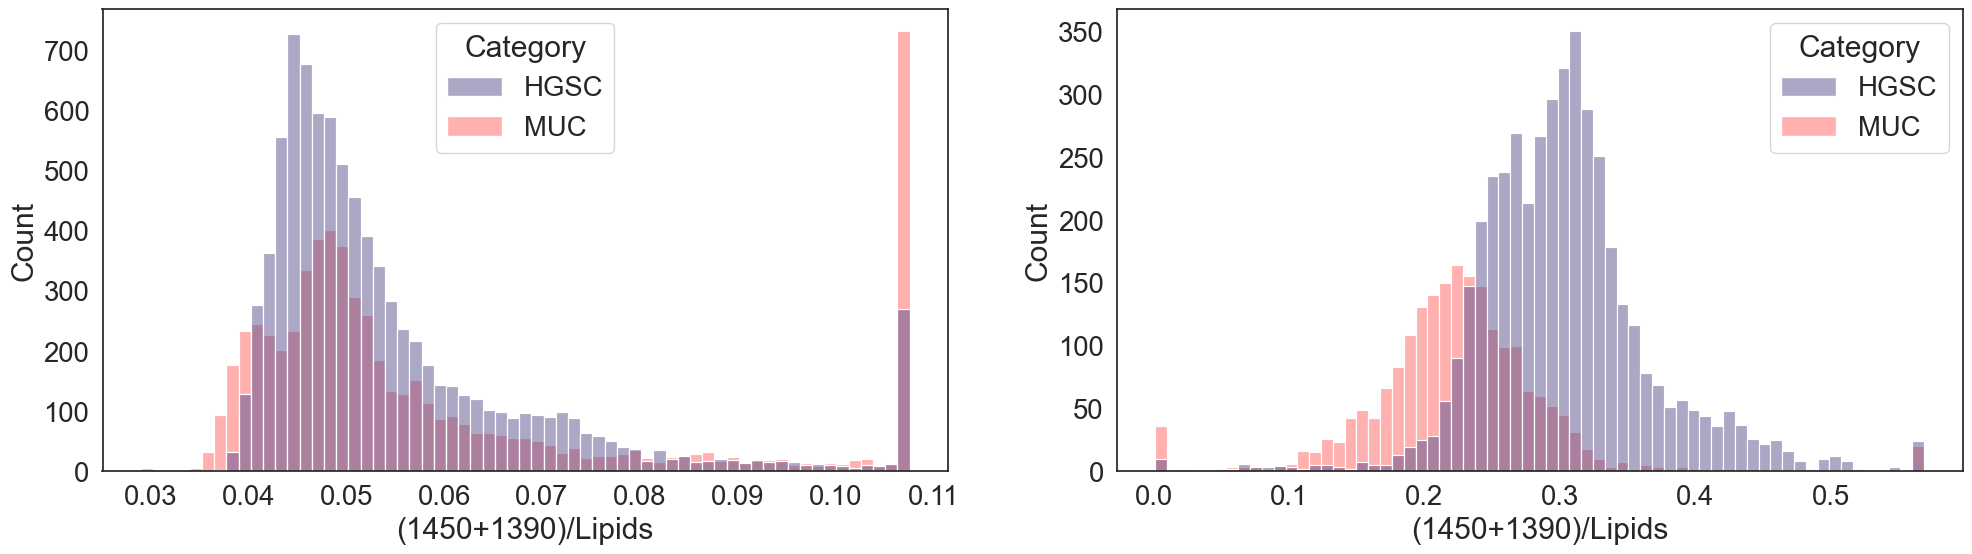

1450/Lipids


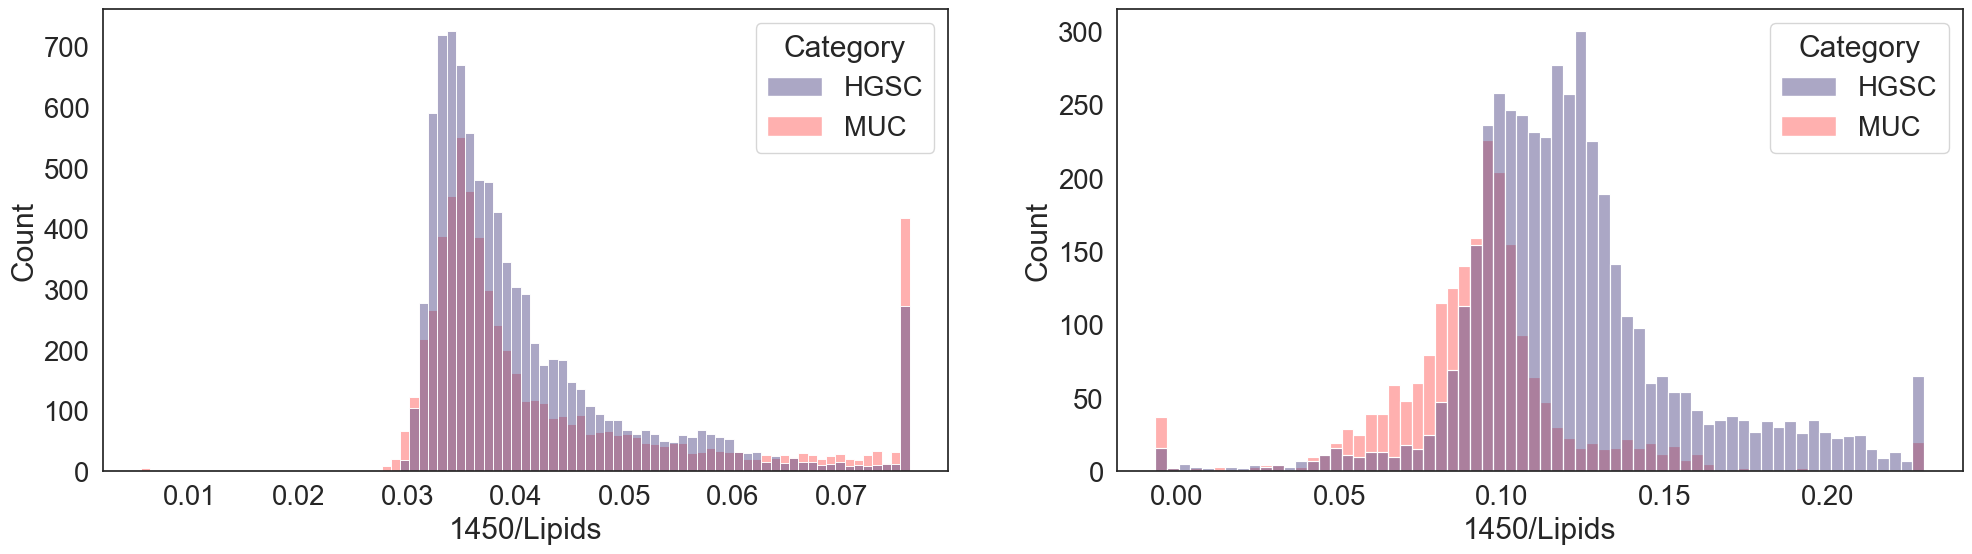

1390/Lipids


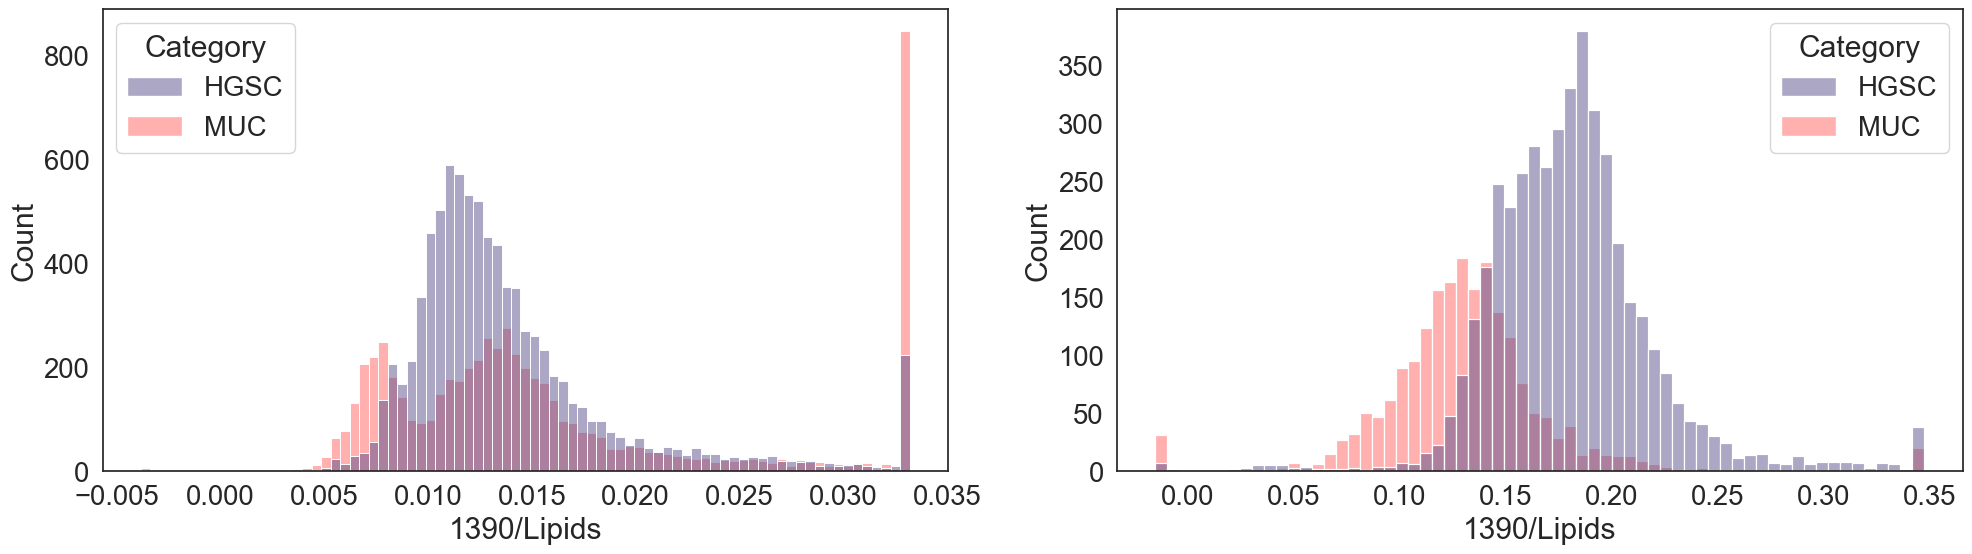

Amide B/Amide I


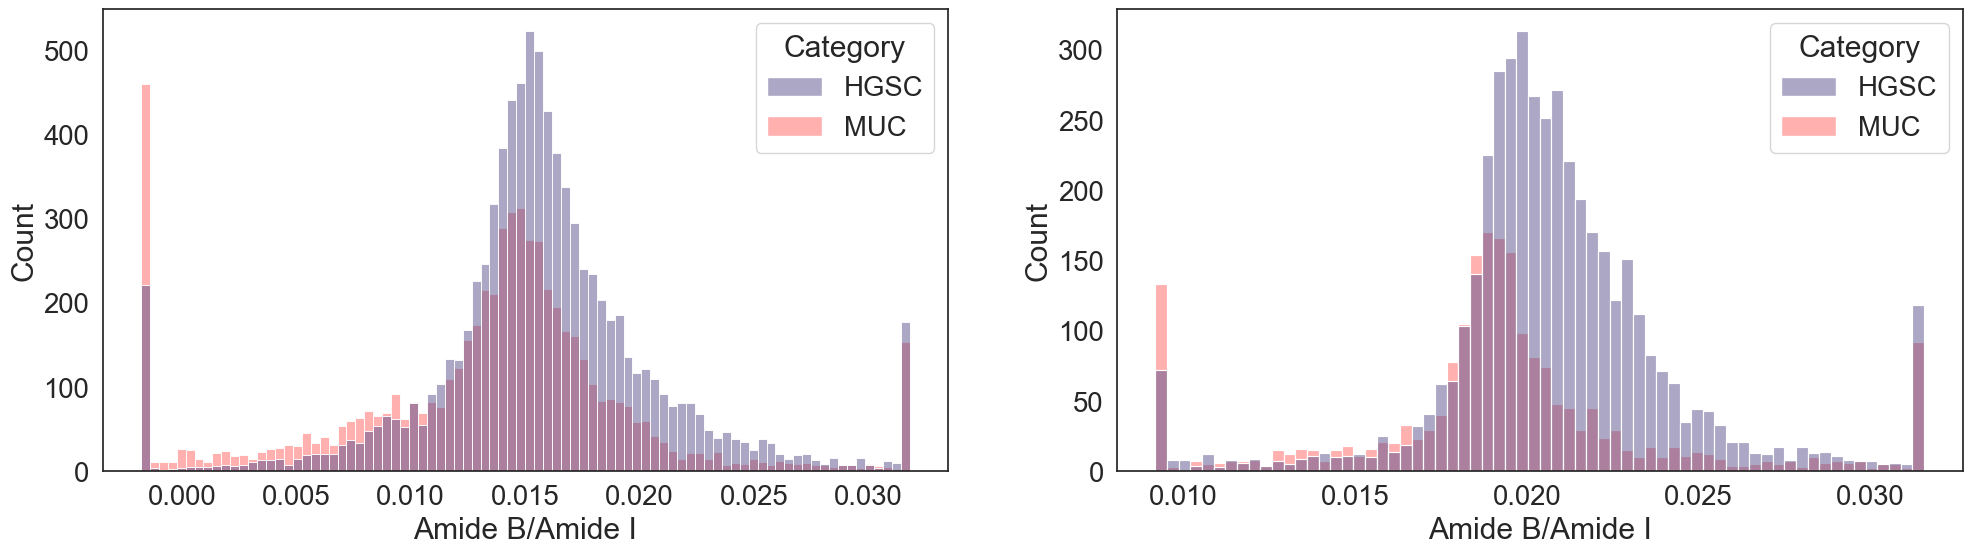

Amide III/Amide B


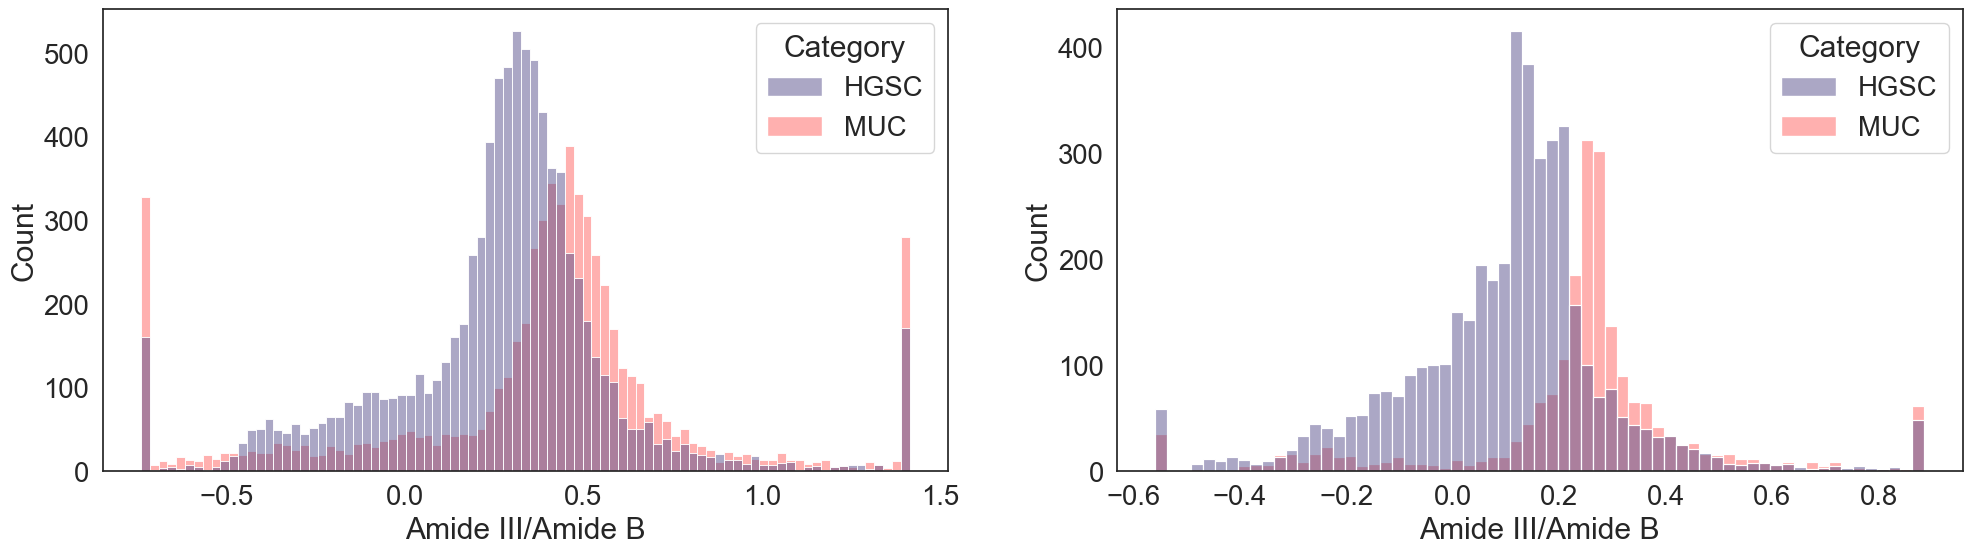

CH3/1450


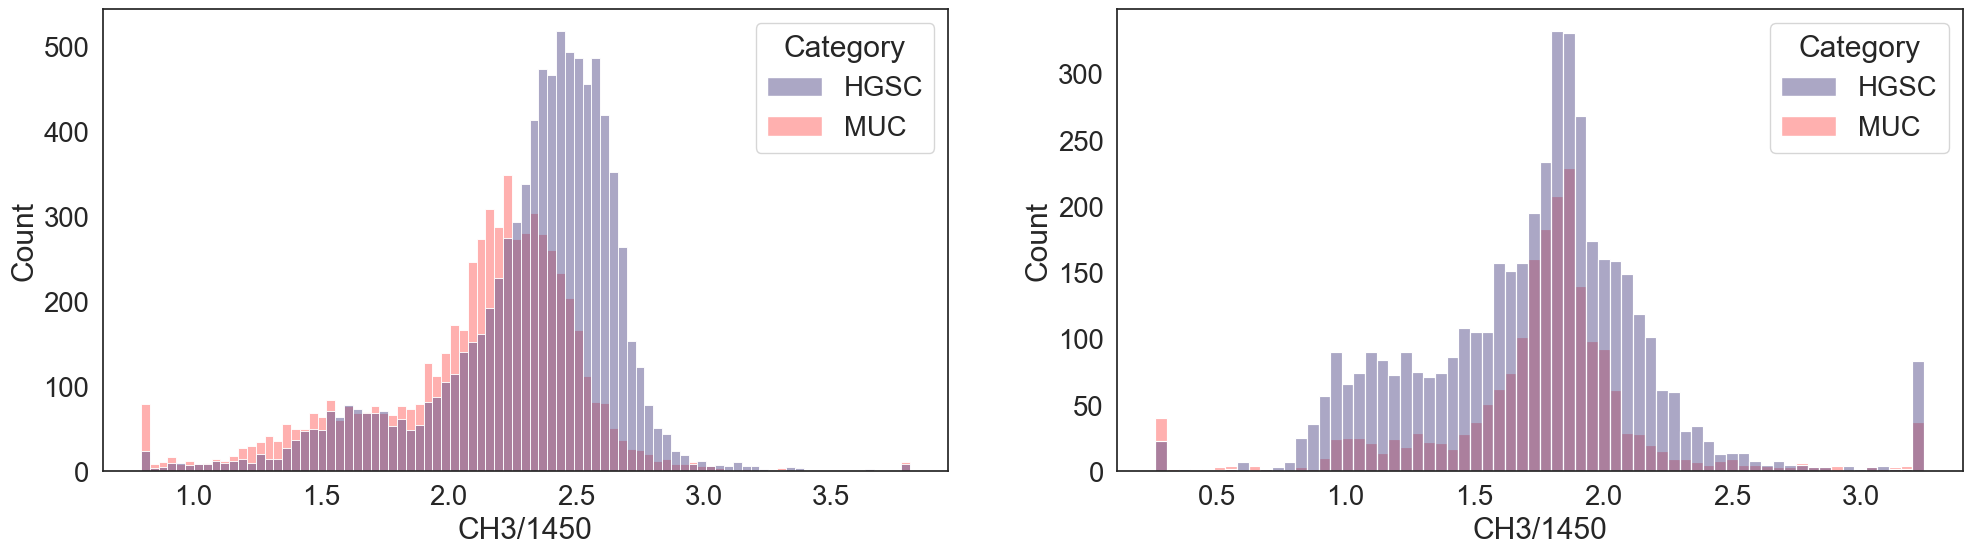

2850/1450


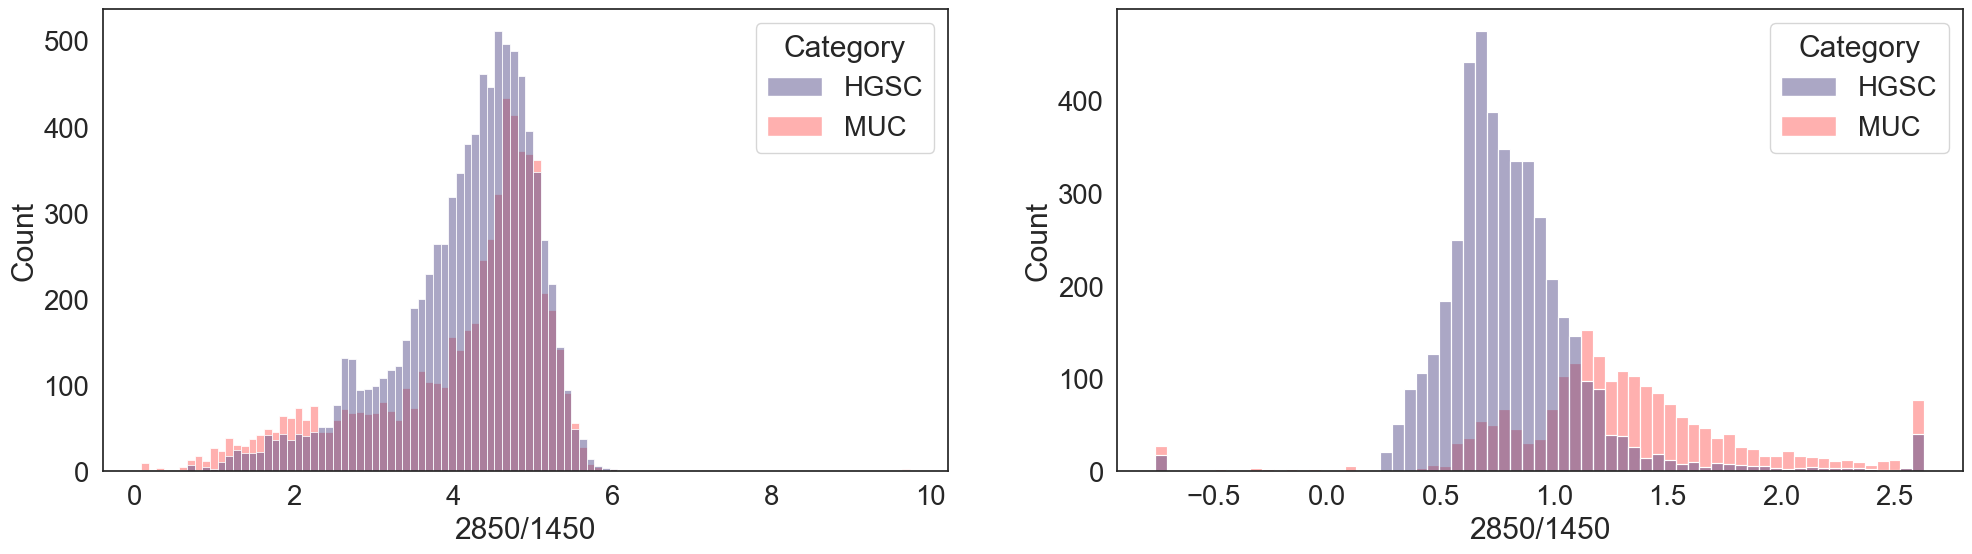

In [26]:
for col in train_DEP_patient_win.select_dtypes(include=[np.number]):
    print(col)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,6))
    sns.histplot(train_PAR_patient_win, x=col, hue='Category', ax=ax1, palette = palette)
    sns.histplot(train_DEP_patient_win, x=col, hue='Category', ax=ax2, palette = palette)
    plt.show()

The histograms suggest that Lipid saturation, 1080/1240 cm^-1, and Amide III/Amide I bands show promise in discriminating between HGSC and MUC samples. Now, let's compare how they discriminate between paraffin-embedded and deparaffinized samples.

In [27]:
# Combine parafine and deparaffinized sample data in one dataset
# Add '_par' suffix to 'Category' column in train_PAR_patient_win
train_PAR_patient_win['Category'] = train_PAR_patient_win['Category'] + '_par'
# Add '_dep' suffix to 'Category' column in train_DEP_patient_win
train_DEP_patient_win['Category'] = train_DEP_patient_win['Category'] + '_dep'
# Concatenate the DataFrames
df = pd.concat([train_PAR_patient_win, train_DEP_patient_win], axis=0)

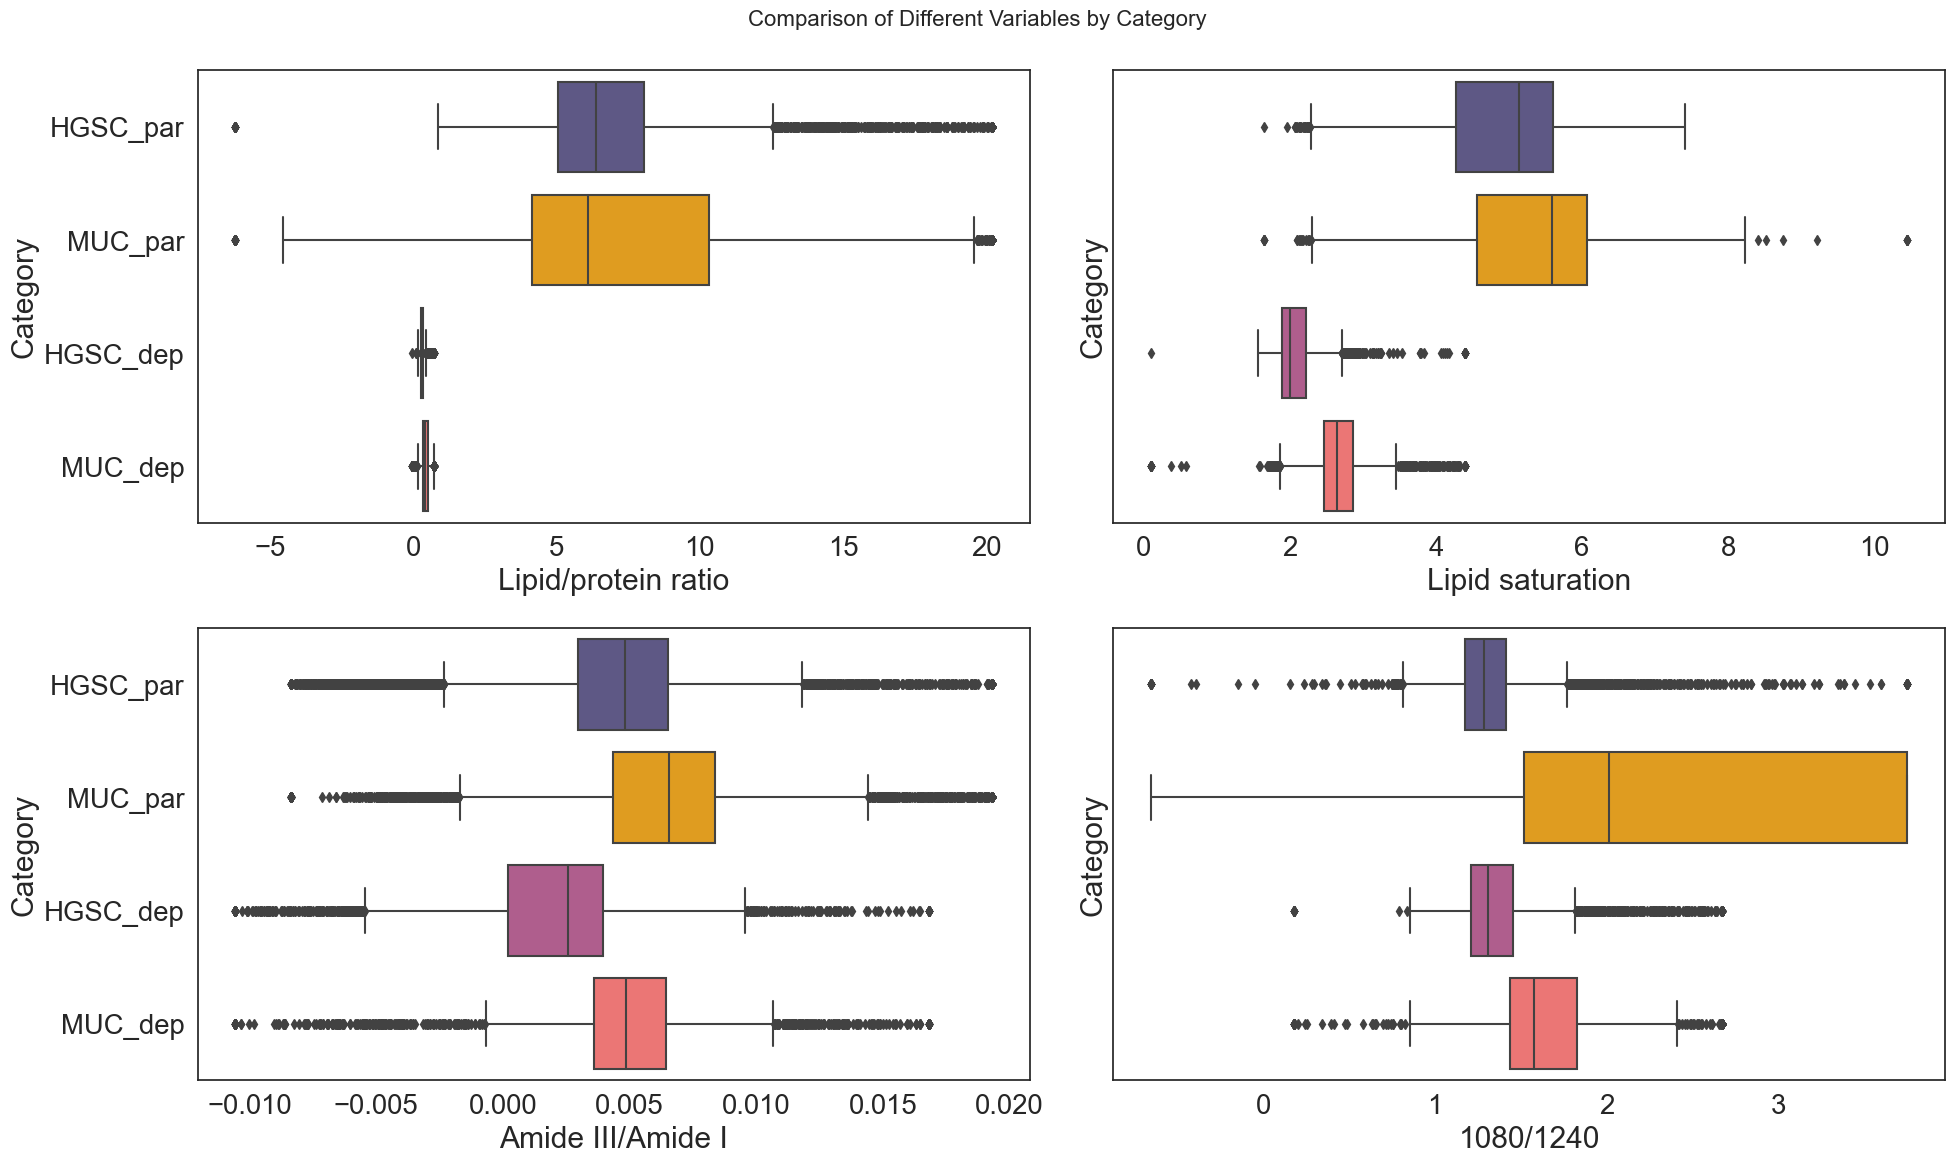

In [28]:
# Create colour palette
palette = ["#58508d","#ffa600", "#bc5090", "#ff6361"]

# Define the columns for the subplots
columns = ['Lipid/protein ratio', 'Lipid saturation', 'Amide III/Amide I', '1080/1240']

# Create a figure and axis objects
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12), sharey=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over each column and plot the corresponding boxplot
for i, col in enumerate(columns):
    sns.boxplot(data=df, x=col, y='Category', ax=axes[i], palette=palette)

# Add a title to the entire figure
plt.suptitle('Comparison of Different Variables by Category', fontsize=16)

# Adjust the layout
plt.tight_layout()
plt.show()

**Deparaffinization notably impacted lipid saturation**, likely due to the **solvent's washing out of lipids**. Specifically, there appears to be a shift in lipid saturation (CH2 vibrational band / CH3 vibrational band), indicating **potentially more effective removal of CH2 groups**. Interestingly, the ratio between Amide III and Amide I bands remained largely unchanged post-deparaffinization, with trends consistent with samples in paraffin. Additionally, bands associated with phosphate groups (1080/1240) remained unaffected by the deparaffinization process.

### 3. Datasets transformation

Now, that we know in what form we want to feed that data in the model, let's transform all the datasets accordingly. In order to avoid data leakage we'll use the outliers limits found  on the training set for Winsorization the outliers in the test data.

In [29]:
def transform_dataset(name):
    try:
        # Split the name into set_type and set_name
        set_type, set_name = name.split('_', 1)
        
        # Import the dataset
        df = pd.read_csv('../data/' + name + '.csv')
        
        # Convert the features to ratios
        df_ratios = to_ratios(df)
        
        # Get outliers limits based on transformed training sets
        if set_type == 'train':
            outlim = outliers_lim_IQR(df_ratios.select_dtypes(include='number'), n=3)
            outlim_df = pd.DataFrame(outlim)
            outlim_df.to_csv('../data/' + set_name + '_outlim.csv')
        elif set_type == 'test':
            # Read previously saved outliers limits
            outlim_df = pd.read_csv('../data/' + set_name + '_outlim.csv')
            outlim = outlim_to_tuple(outlim_df)
        else:
            print('Unknown type of set')
        
        # Winsorize the data based on outliers limits
        df_win = winsorize_outliers(df_ratios, outlim)
        
        # Export dataset with winsorized outliers
        df_win.to_csv('../data/' + name + '_win.csv', index=False)
        
    except FileNotFoundError:
        print(f'File {name}.csv not found.')

In [30]:
transform_dataset('train_PAR_patient')
transform_dataset('train_DEP_patient')
transform_dataset('test_PAR_patient')
transform_dataset('test_DEP_patient')
transform_dataset('train_PAR_entry')
transform_dataset('train_DEP_entry')
transform_dataset('test_PAR_entry')
transform_dataset('test_DEP_entry')

The data is now prepared for model construction. The introduction of new variables derived from calculating ratios of specific bands intensities significantly enhances the flexibility in preparing data for future applications.